In [1]:
from os.path import abspath, expanduser

import warnings

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter

from datetime import datetime

from sklearn.mixture import GaussianMixture

import numpy as np
import pandas as pd
import rasters as rt
from rasters import Raster, RasterGeometry

from ECOv002_CMR import ECOSTRESS_CMR_search, download_file, GranuleID, download_ECOSTRESS_granule
from ECOv002_granules import ET_COLORMAP, NDVI_COLORMAP

from PTJPL import PTJPL, load_fAPARmax, load_Topt, daily_Rn_integration_verma

%matplotlib inline

In [2]:
import logging

logging.getLogger().handlers = []

In [3]:
aquisition_date = "2024-10-22"
orbit = 35698
scene = 14
tile = "11SPS"
ECOSTRESS_download_directory = "~/Documents/ECOSTRESS/ET_sensitivity"
static_directory = "~/Documents/ECOSTRESS/ET_sensitivity"
working_directory = "~/Documents/ECOSTRESS/ET_sensitivity"

In [4]:
error_cmap = LinearSegmentedColormap.from_list("error", ["blue", "white", "red"])

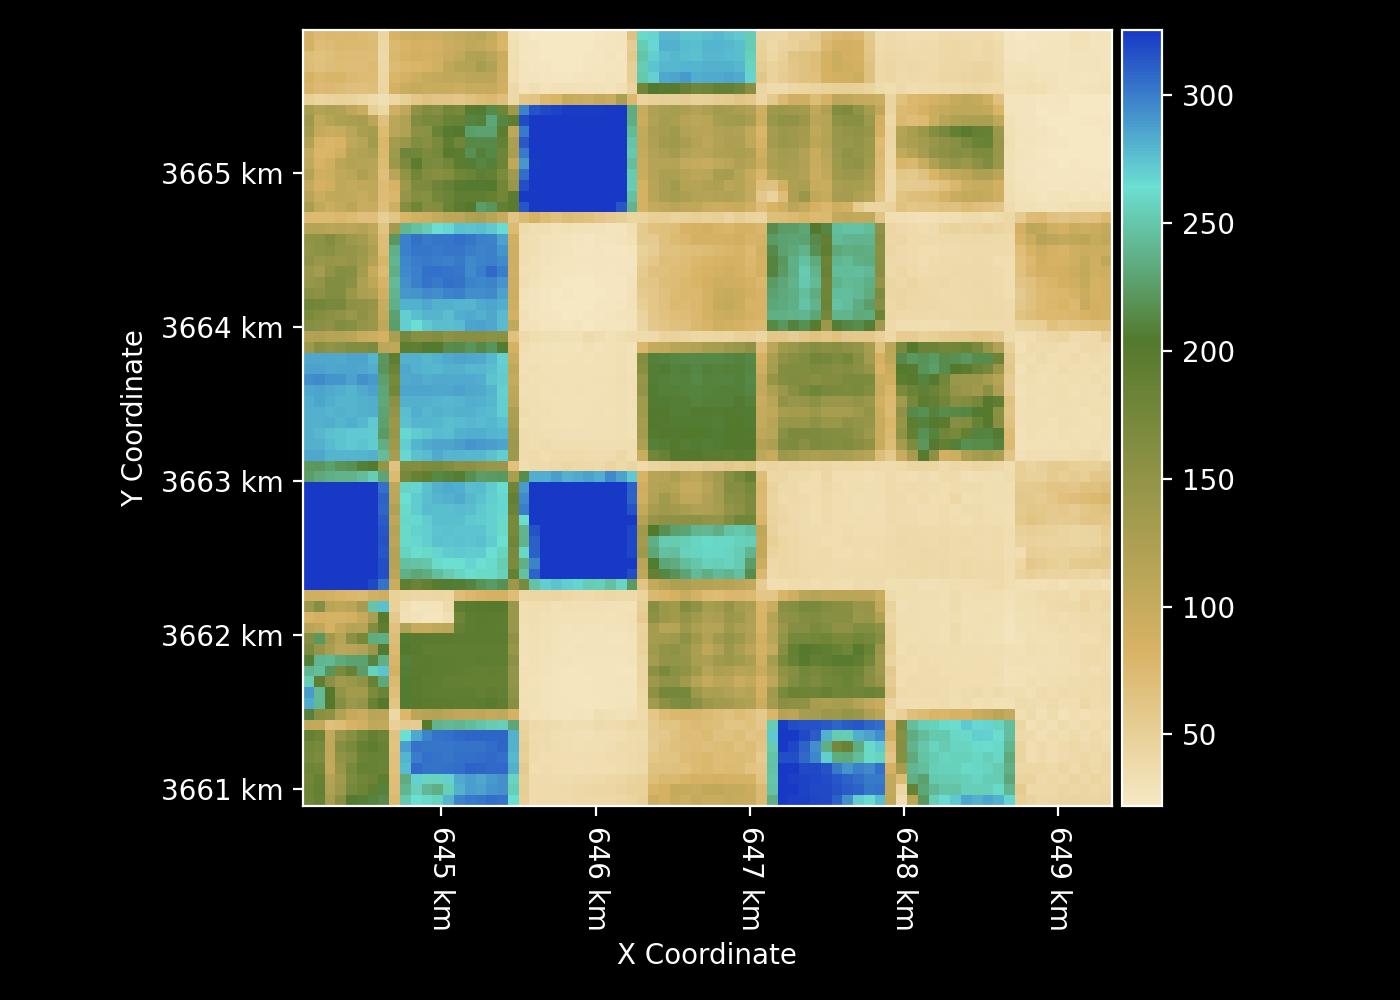

In [5]:
subset = rt.Raster.open("farms_subset.tif")
subset.cmap = ET_COLORMAP
subset

In [6]:
geometry = subset.geometry
geometry

{
  "dimensions": {
    "rows": 72,
    "cols": 75
  },
  "bbox": {
    "xmin": 644100.0,
    "ymin": 3660890.0,
    "xmax": 649350.0,
    "ymax": 3665930.0
  },
  "crs": "EPSG:32611",
  "resolution": {
    "cell_width": 70.0,
    "cell_height": -70.0
  }
}

In [7]:
L2T_LSTE_granule = download_ECOSTRESS_granule(
    product="L2T_LSTE", 
    orbit=orbit,
    scene=scene,
    tile=tile, 
    aquisition_date=aquisition_date,
    parent_directory=ECOSTRESS_download_directory
)

L2T_LSTE_granule

L2TLSTE("/Users/halverso/Documents/ECOSTRESS/ET_sensitivity/ECOv002_L2T_LSTE_35698_014_11SPS_20241022T183627_0713_01")

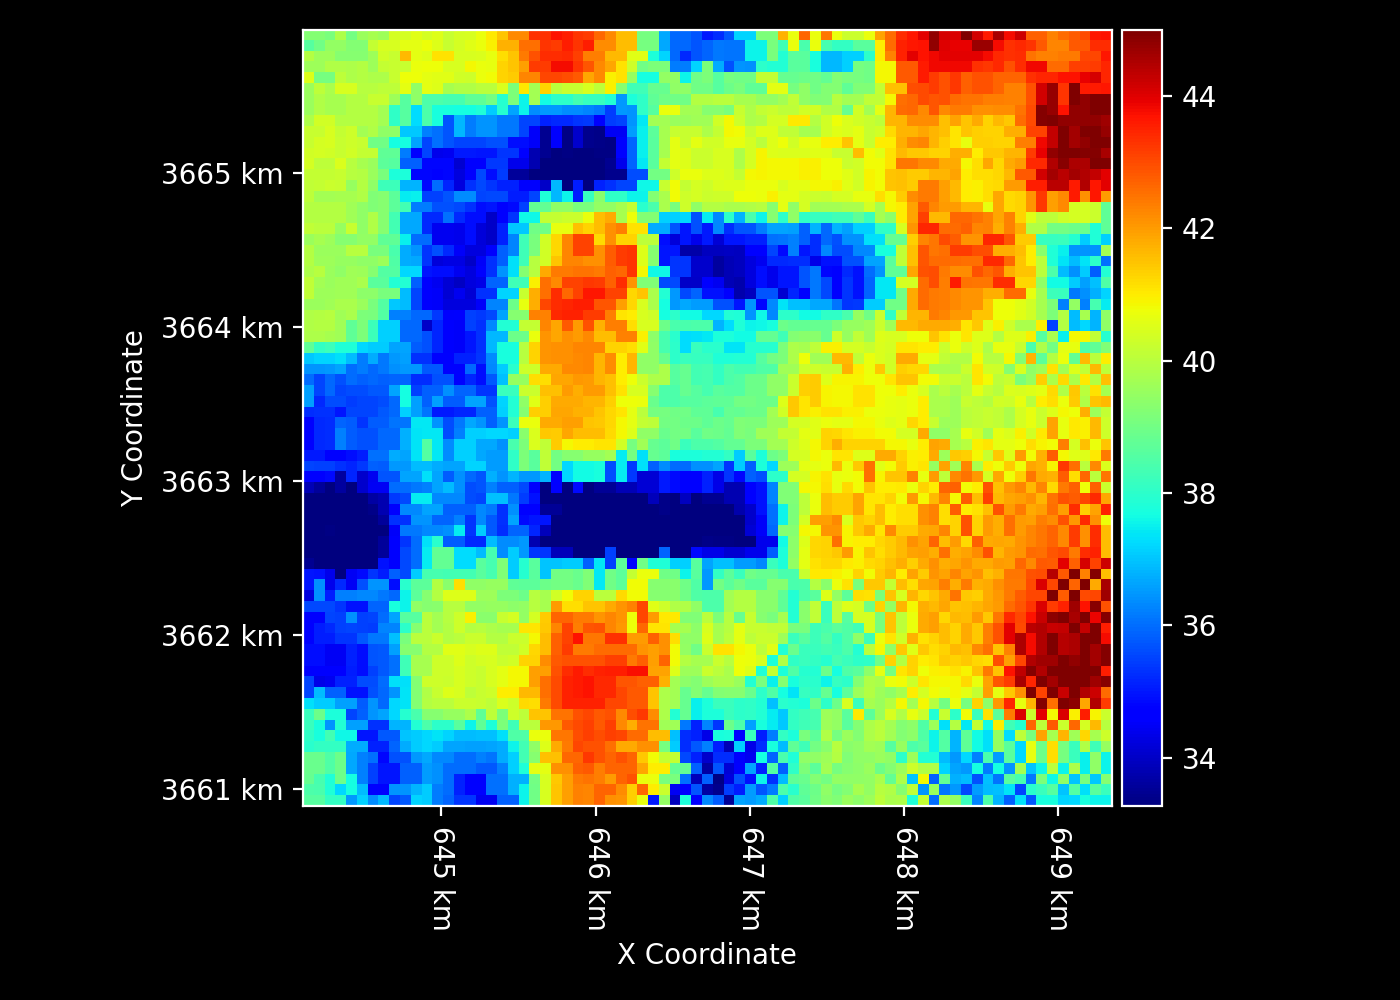

In [8]:
ST_C = L2T_LSTE_granule.ST_C.to_geometry(geometry)
ST_C

In [9]:
L2T_STARS_granule = download_ECOSTRESS_granule(
    product="L2T_STARS", 
    tile=tile, 
    aquisition_date=aquisition_date,
    parent_directory=ECOSTRESS_download_directory
)

L2T_STARS_granule

L2TSTARS("/Users/halverso/Documents/ECOSTRESS/ET_sensitivity/ECOv002_L2T_STARS_11SPS_20241022_0713_01")

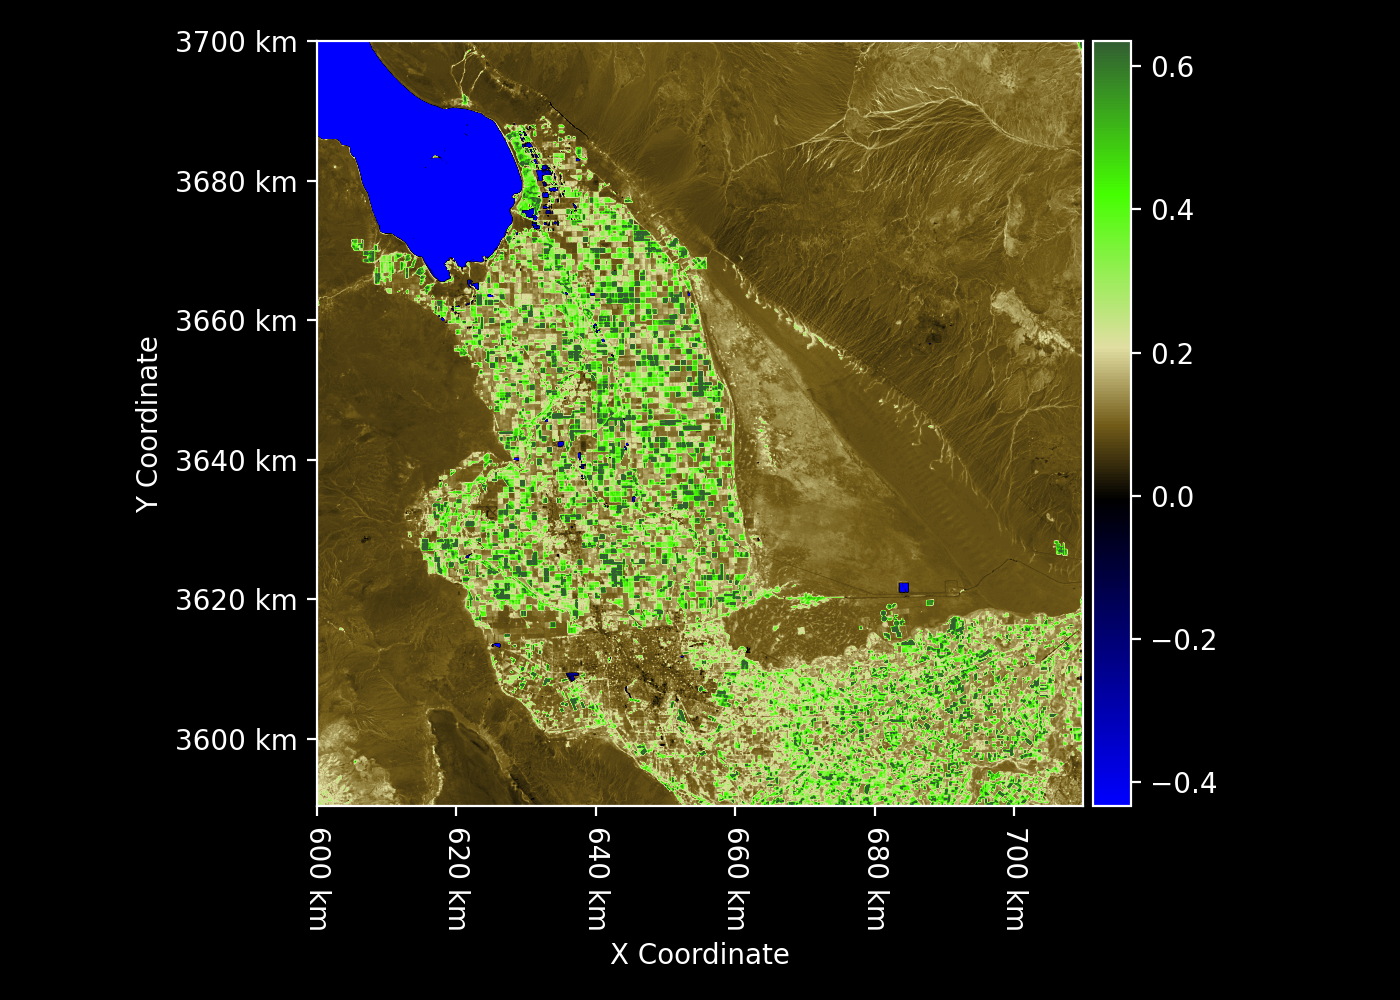

In [10]:
NDVI_tile = L2T_STARS_granule.NDVI
NDVI_tile

In [11]:
tile_geometry = NDVI_tile.geometry
tile_geometry

{
  "dimensions": {
    "rows": 1568,
    "cols": 1568
  },
  "bbox": {
    "xmin": 600000.0,
    "ymin": 3590260.0,
    "xmax": 709760.0,
    "ymax": 3700020.0
  },
  "crs": "EPSG:32611",
  "resolution": {
    "cell_width": 70.0,
    "cell_height": -70.0
  }
}

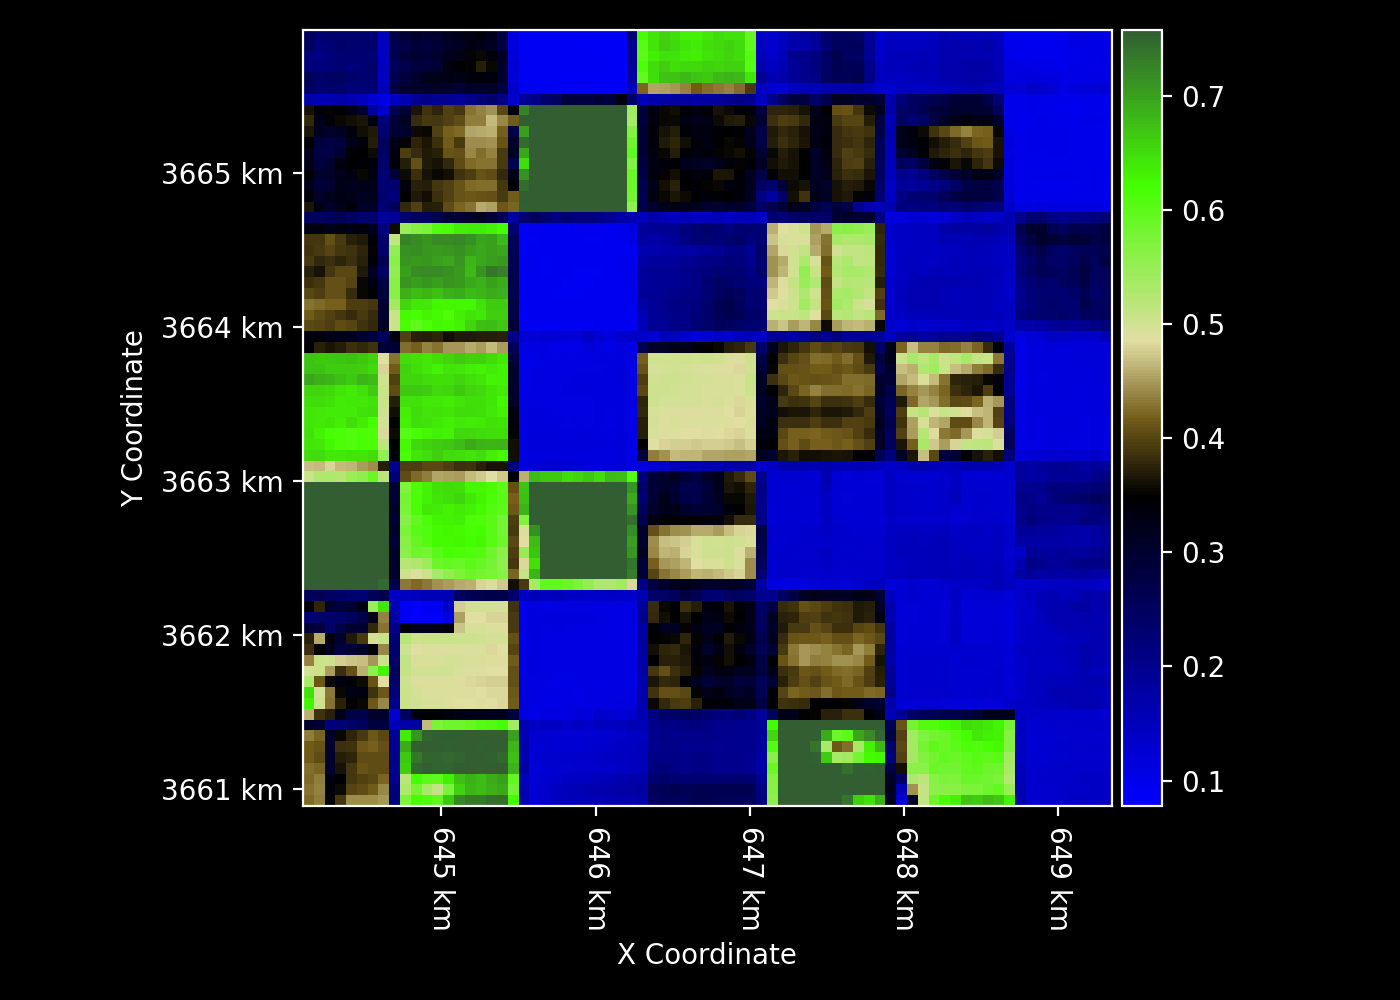

In [12]:
NDVI = NDVI_tile.to_geometry(geometry)
NDVI

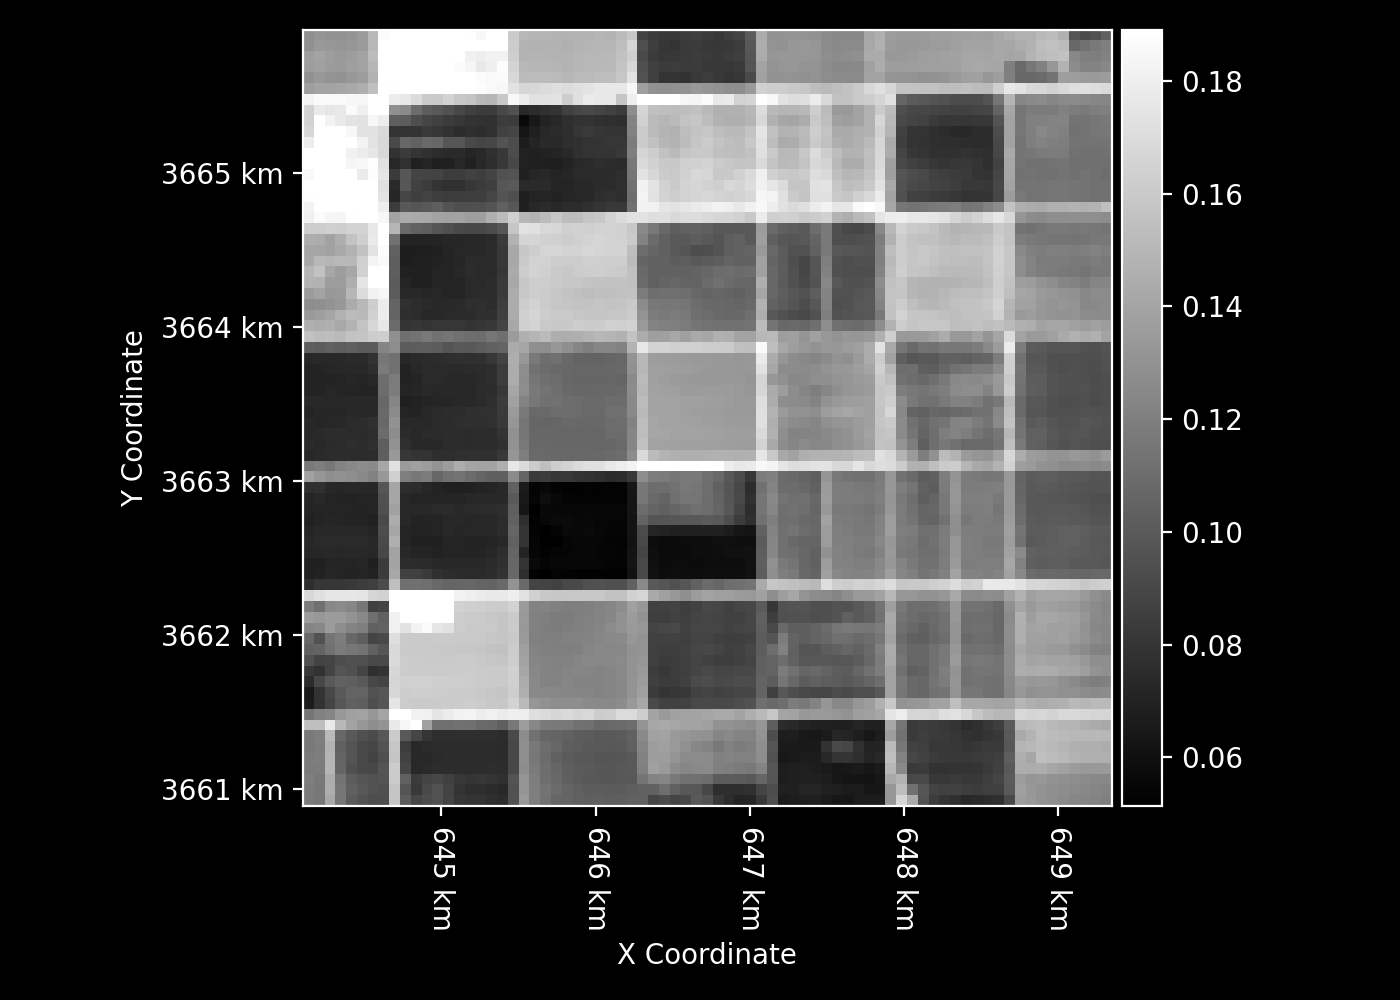

In [13]:
albedo = L2T_STARS_granule.albedo.to_geometry(geometry)
albedo

Download the ECOSTRESS Collection 2 Surface Energy Balance (SEB) product

In [14]:
L3T_SEB_granule = download_ECOSTRESS_granule(
    product="L3T_SEB", 
    orbit=orbit,
    scene=scene,
    tile=tile, 
    aquisition_date=aquisition_date,
    parent_directory=ECOSTRESS_download_directory
)

L3T_SEB_granule

L3TSEB("/Users/halverso/Documents/ECOSTRESS/ET_sensitivity/ECOv002_L3T_SEB_35698_014_11SPS_20241022T183627_0713_01")

Load instantaneous net radiation (Rn) from the SEB product

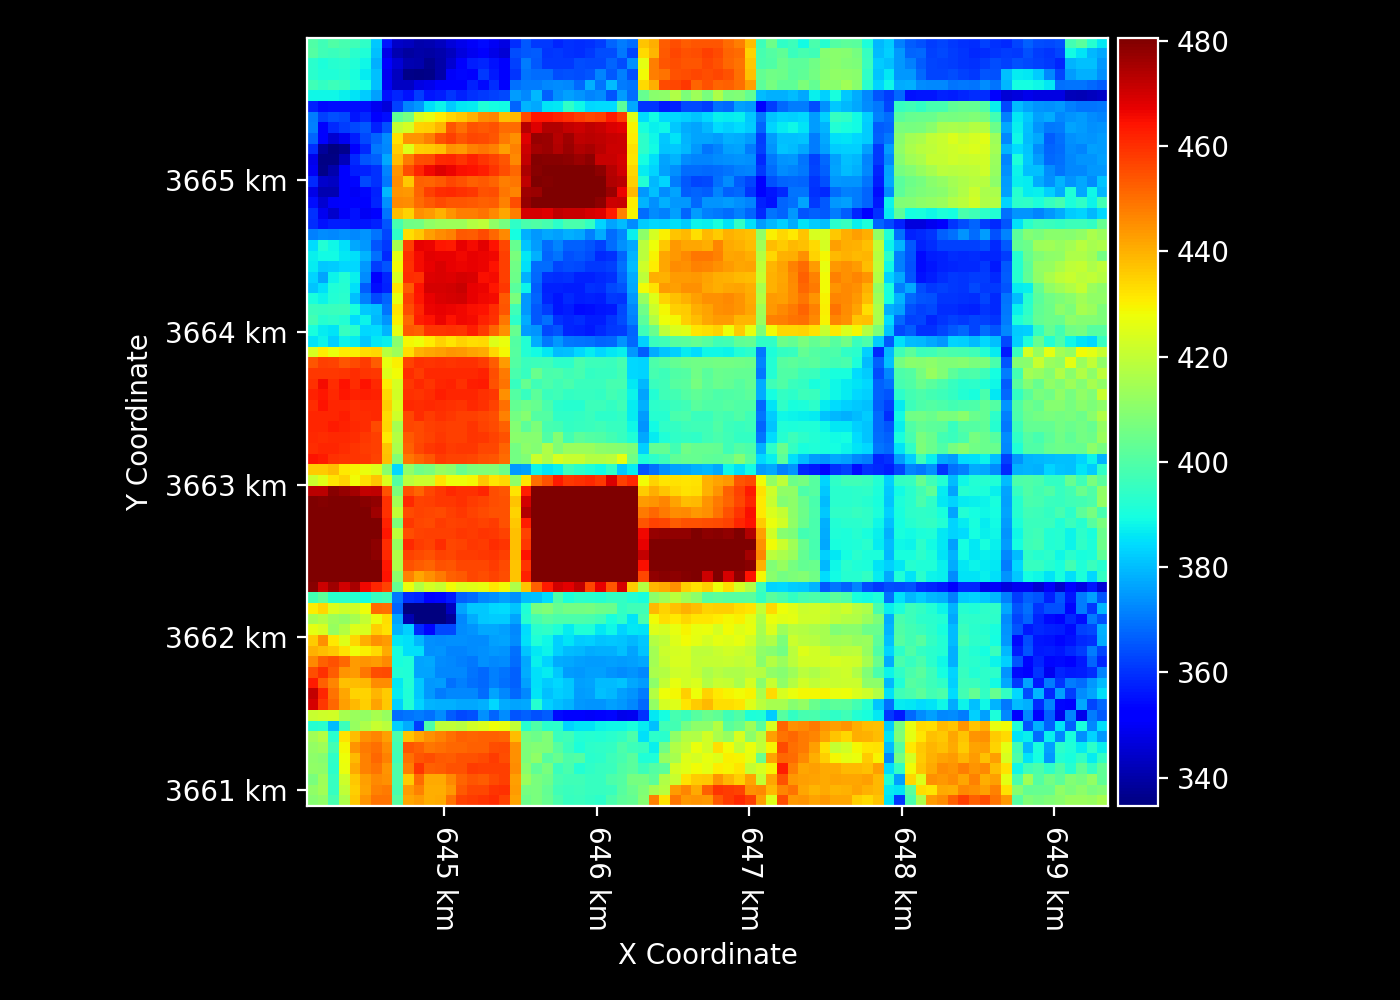

In [15]:
Rn = L3T_SEB_granule.variable("Rn").to_geometry(geometry)
Rn

In [16]:
def calculate_UTC_offset_hours(geometry: RasterGeometry) -> Raster:
    return Raster(np.radians(geometry.lon) / np.pi * 12, geometry=geometry)

def calculate_day_of_year(time_UTC: datetime, geometry: RasterGeometry) -> Raster:
    doy_UTC = time_UTC.timetuple().tm_yday
    hour_UTC = time_UTC.hour + time_UTC.minute / 60 + time_UTC.second / 3600
    UTC_offset_hours = calculate_UTC_offset_hours(geometry=geometry)
    hour_of_day = hour_UTC + UTC_offset_hours
    doy = doy_UTC
    doy = rt.where(hour_of_day < 0, doy - 1, doy)
    doy = rt.where(hour_of_day > 24, doy + 1, doy)

    return doy

def calculate_hour_of_day(time_UTC: datetime, geometry: RasterGeometry) -> Raster:
    hour_UTC = time_UTC.hour + time_UTC.minute / 60 + time_UTC.second / 3600
    UTC_offset_hours = calculate_UTC_offset_hours(geometry=geometry)
    hour_of_day = hour_UTC + UTC_offset_hours
    hour_of_day = rt.where(hour_of_day < 0, hour_of_day + 24, hour_of_day)
    hour_of_day = rt.where(hour_of_day > 24, hour_of_day - 24, hour_of_day)

    return hour_of_day

def day_angle_rad_from_doy(doy: Raster) -> Raster:
    """
    This function calculates day angle in radians from day of year between 1 and 365.
    """
    return (2 * np.pi * (doy - 1)) / 365

def solar_dec_deg_from_day_angle_rad(day_angle_rad: float) -> float:
    """
    This function calculates solar declination in degrees from day angle in radians.
    """
    return (0.006918 - 0.399912 * np.cos(day_angle_rad) + 0.070257 * np.sin(day_angle_rad) - 0.006758 * np.cos(
        2 * day_angle_rad) + 0.000907 * np.sin(2 * day_angle_rad) - 0.002697 * np.cos(
        3 * day_angle_rad) + 0.00148 * np.sin(
        3 * day_angle_rad)) * (180 / np.pi)

def SHA_deg_from_doy_lat(doy: Raster, latitude: np.ndarray) -> Raster:
    """
    This function calculates sunrise hour angle in degrees from latitude in degrees and day of year between 1 and 365.
    """
    # calculate day angle in radians
    day_angle_rad = day_angle_rad_from_doy(doy)

    # calculate solar declination in degrees
    solar_dec_deg = solar_dec_deg_from_day_angle_rad(day_angle_rad)

    # convert latitude to radians
    latitude_rad = np.radians(latitude)

    # convert solar declination to radians
    solar_dec_rad = np.radians(solar_dec_deg)

    # calculate cosine of sunrise angle at latitude and solar declination
    # need to keep the cosine for polar correction
    sunrise_cos = -np.tan(latitude_rad) * np.tan(solar_dec_rad)

    # calculate sunrise angle in radians from cosine
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        sunrise_rad = np.arccos(sunrise_cos)

    # convert to degrees
    sunrise_deg = np.degrees(sunrise_rad)

    # apply polar correction
    sunrise_deg = rt.where(sunrise_cos >= 1, 0, sunrise_deg)
    sunrise_deg = rt.where(sunrise_cos <= -1, 180, sunrise_deg)

    return sunrise_deg

def sunrise_from_sha(sha_deg: Raster) -> Raster:
    """
    This function calculates sunrise hour from sunrise hour angle in degrees.
    """
    return 12.0 - (sha_deg / 15.0)

def daylight_from_sha(sha_deg: Raster) -> Raster:
    """
    This function calculates daylight hours from sunrise hour angle in degrees.
    """
    return (2.0 / 15.0) * sha_deg

In [17]:
time_UTC = L3T_SEB_granule.time_UTC
time_UTC

datetime.datetime(2024, 10, 22, 18, 36, 27)

/opt/homebrew/Caskroom/miniforge/base/envs/PTJPL/lib/python3.11/site-packages/rasters/raster.py:1740: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  plt.switch_backend(prior_backend)


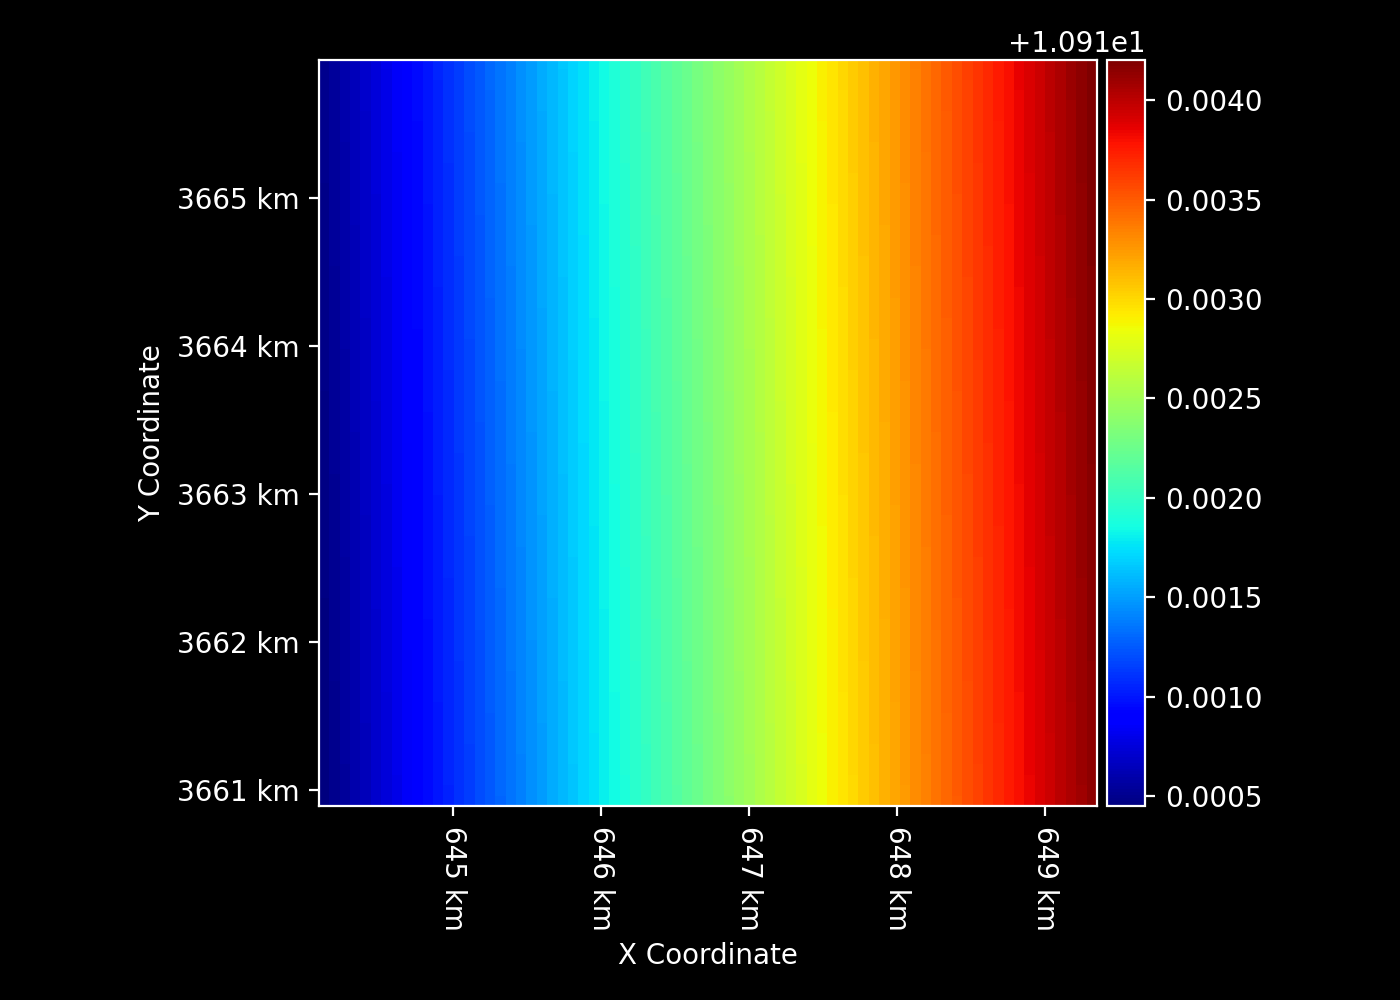

In [18]:
hour_of_day = calculate_hour_of_day(time_UTC, geometry)
hour_of_day

/opt/homebrew/Caskroom/miniforge/base/envs/PTJPL/lib/python3.11/site-packages/rasters/raster.py:1740: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  plt.switch_backend(prior_backend)


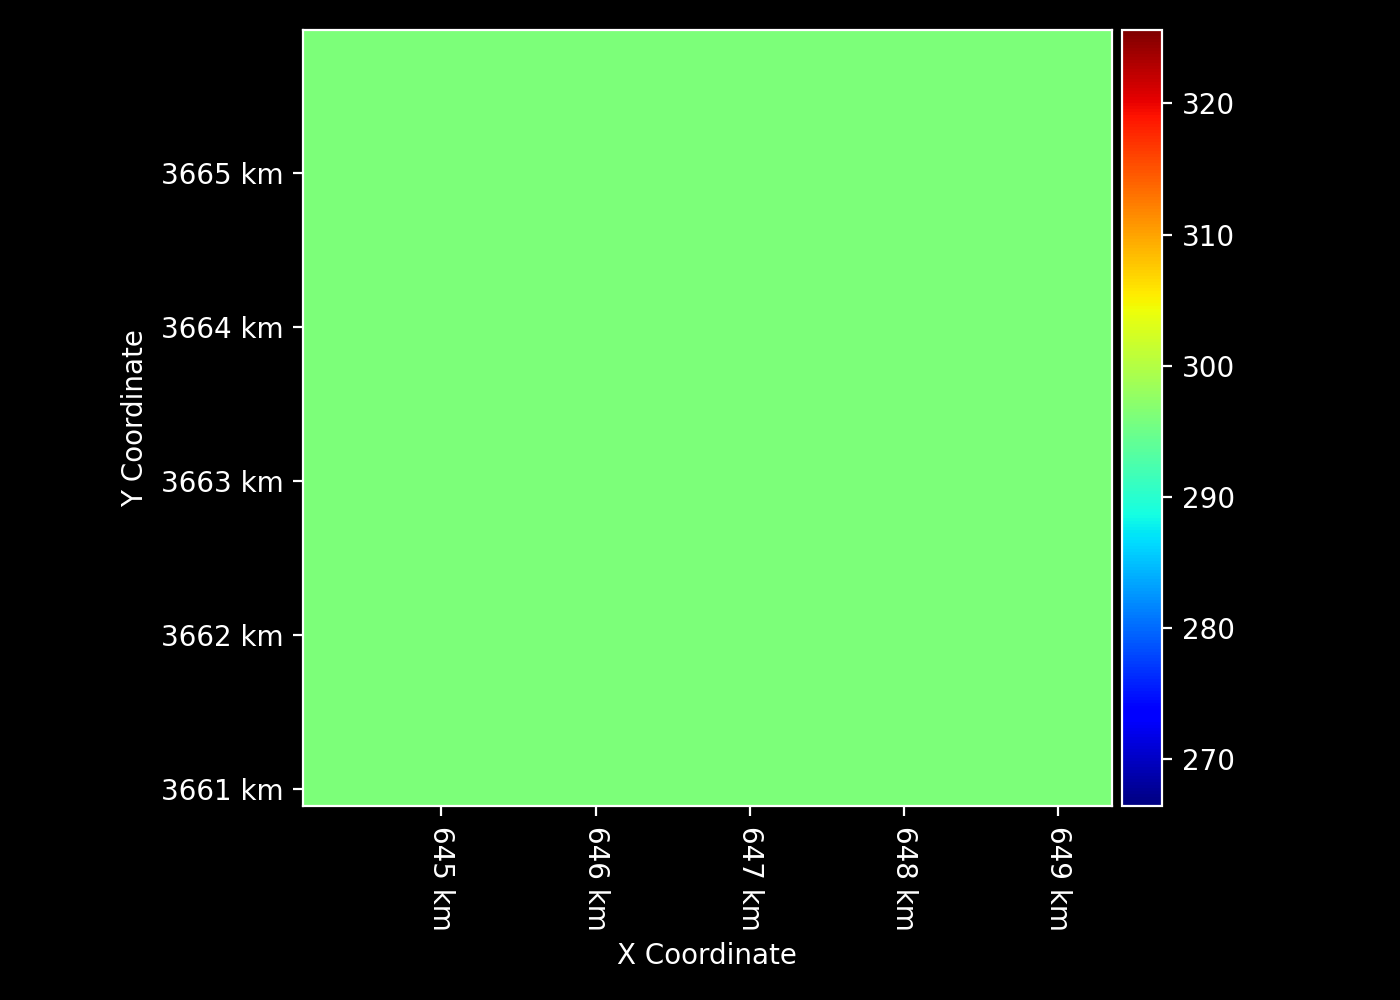

In [19]:
day_of_year = calculate_day_of_year(time_UTC, geometry)
day_of_year

In [20]:
lat = geometry.lat
lat

array([[33.12218901, 33.12217971, 33.1221704 , ..., 33.12150754,
        33.12149791, 33.12148827],
       [33.12155783, 33.12154852, 33.12153921, ..., 33.12087637,
        33.12086674, 33.12085711],
       [33.12092664, 33.12091734, 33.12090803, ..., 33.1202452 ,
        33.12023557, 33.12022594],
       ...,
       [33.07863717, 33.07862788, 33.07861859, ..., 33.07795682,
        33.07794721, 33.07793759],
       [33.07800598, 33.07799669, 33.0779874 , ..., 33.07732565,
        33.07731603, 33.07730642],
       [33.07737479, 33.0773655 , 33.07735621, ..., 33.07669448,
        33.07668486, 33.07667524]])

/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_68573/1571430220.py:34: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (0.006918 - 0.399912 * np.cos(day_angle_rad) + 0.070257 * np.sin(day_angle_rad) - 0.006758 * np.cos(
/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_68573/1571430220.py:35: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  2 * day_angle_rad) + 0.000907 * np.sin(2 * day_angle_rad) - 0.002697 * np.cos(
/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_68573/1571430220.py:36: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  3 * day_angle_rad) + 0.00148 * np.sin(
/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_68573/1571430220.py:53: DeprecationWarning: __array_

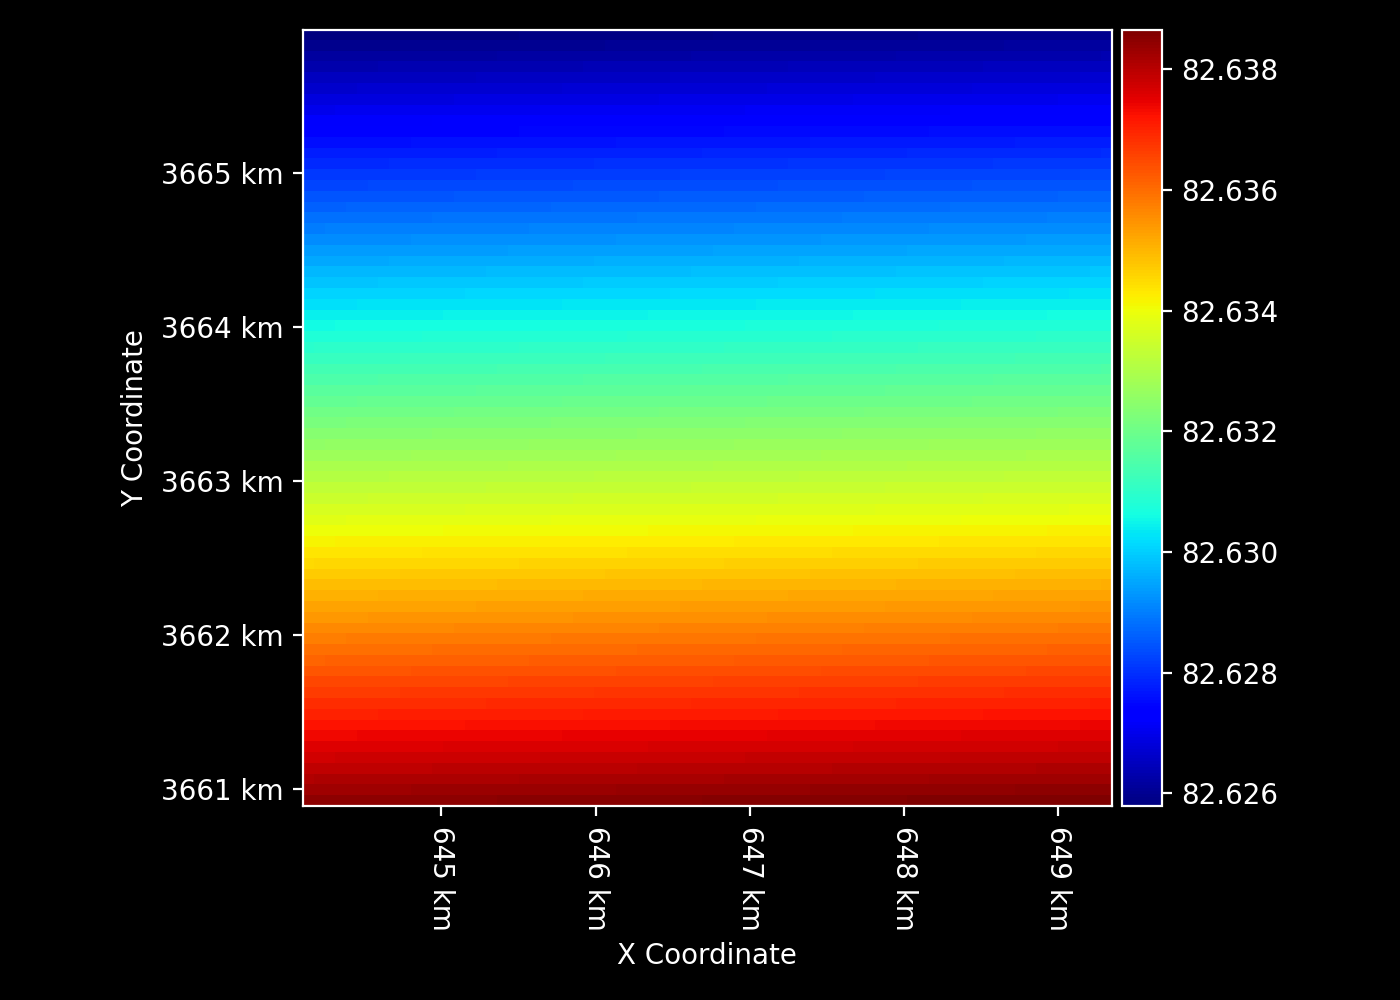

In [21]:
SHA = SHA_deg_from_doy_lat(doy=day_of_year, latitude=lat)
SHA

/opt/homebrew/Caskroom/miniforge/base/envs/PTJPL/lib/python3.11/site-packages/rasters/raster.py:1740: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  plt.switch_backend(prior_backend)


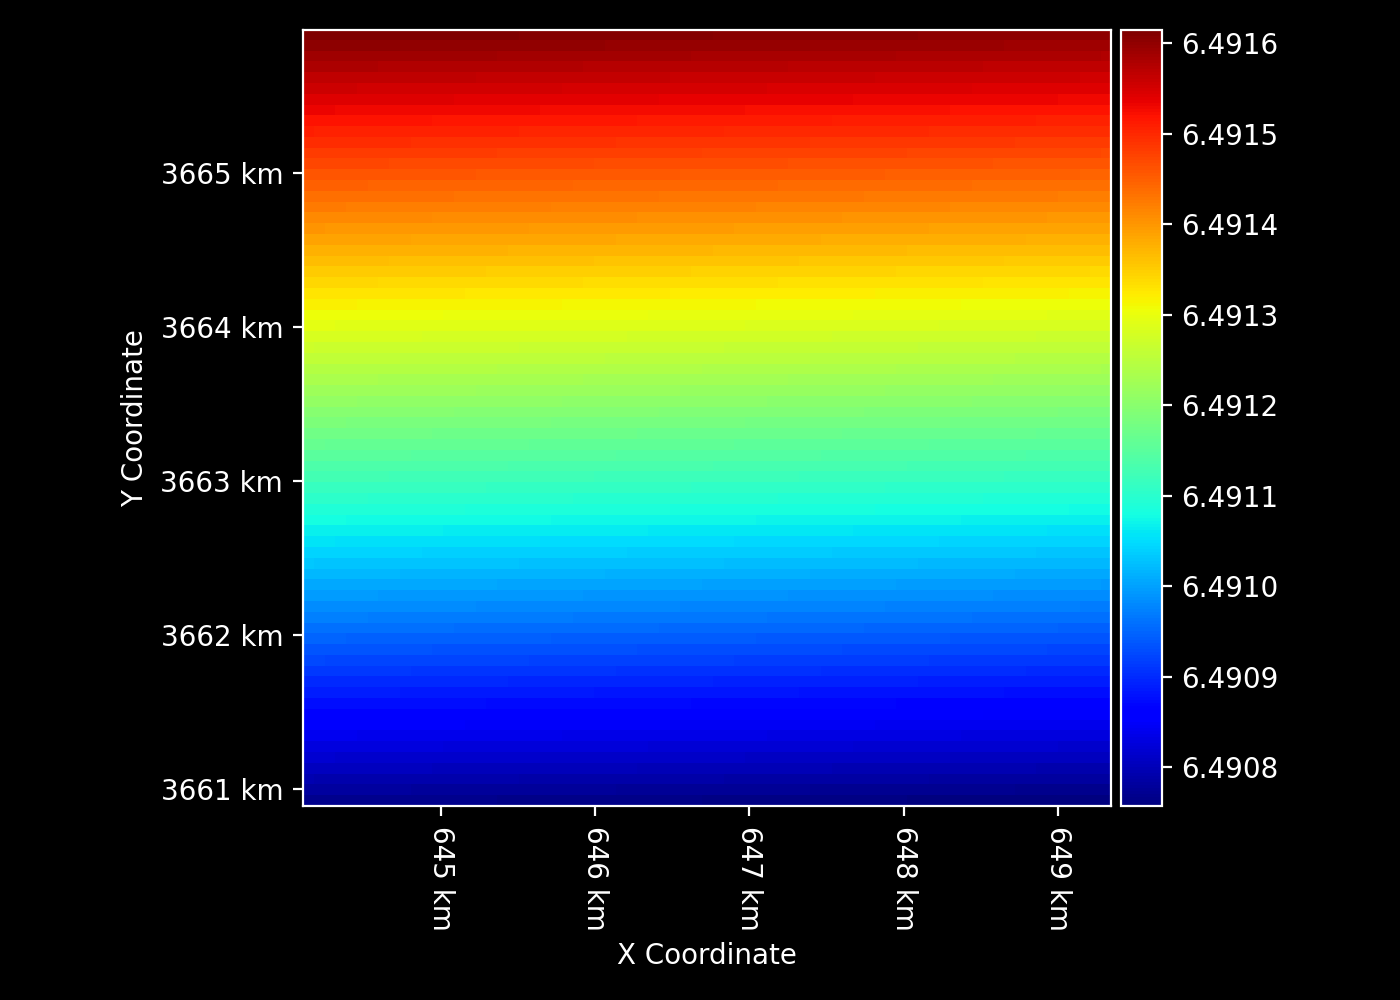

In [22]:
sunrise_hour = sunrise_from_sha(SHA)
sunrise_hour

/opt/homebrew/Caskroom/miniforge/base/envs/PTJPL/lib/python3.11/site-packages/rasters/raster.py:1740: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  plt.switch_backend(prior_backend)


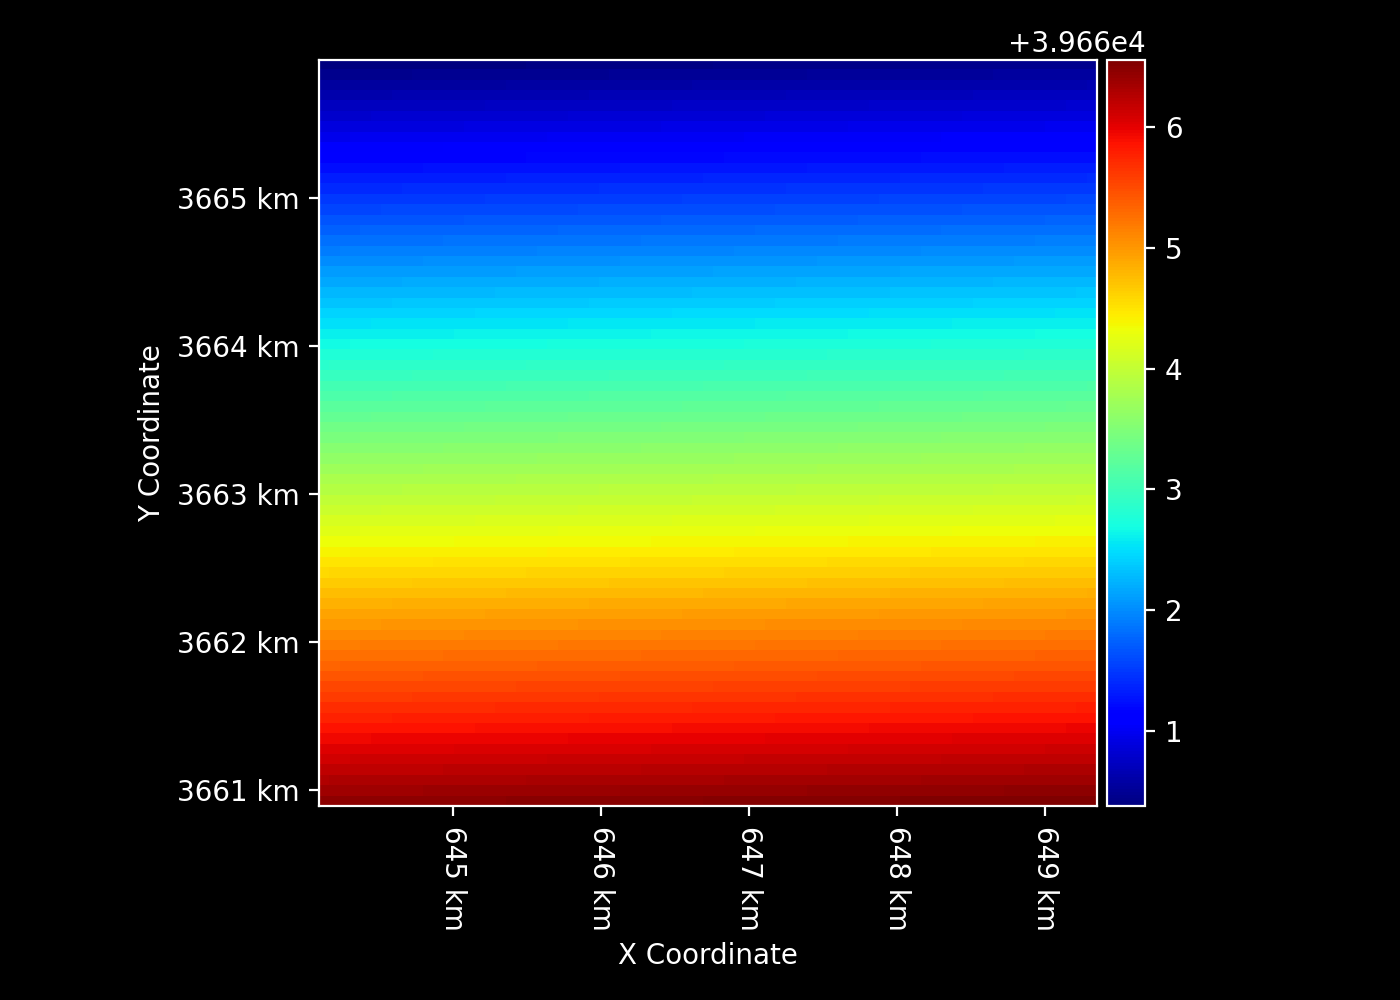

In [23]:
daylight_hours = daylight_from_sha(SHA)
daylight_seconds = daylight_hours * 3600.0
daylight_seconds

/opt/homebrew/Caskroom/miniforge/base/envs/PTJPL/lib/python3.11/site-packages/rasters/raster.py:1740: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  plt.switch_backend(prior_backend)


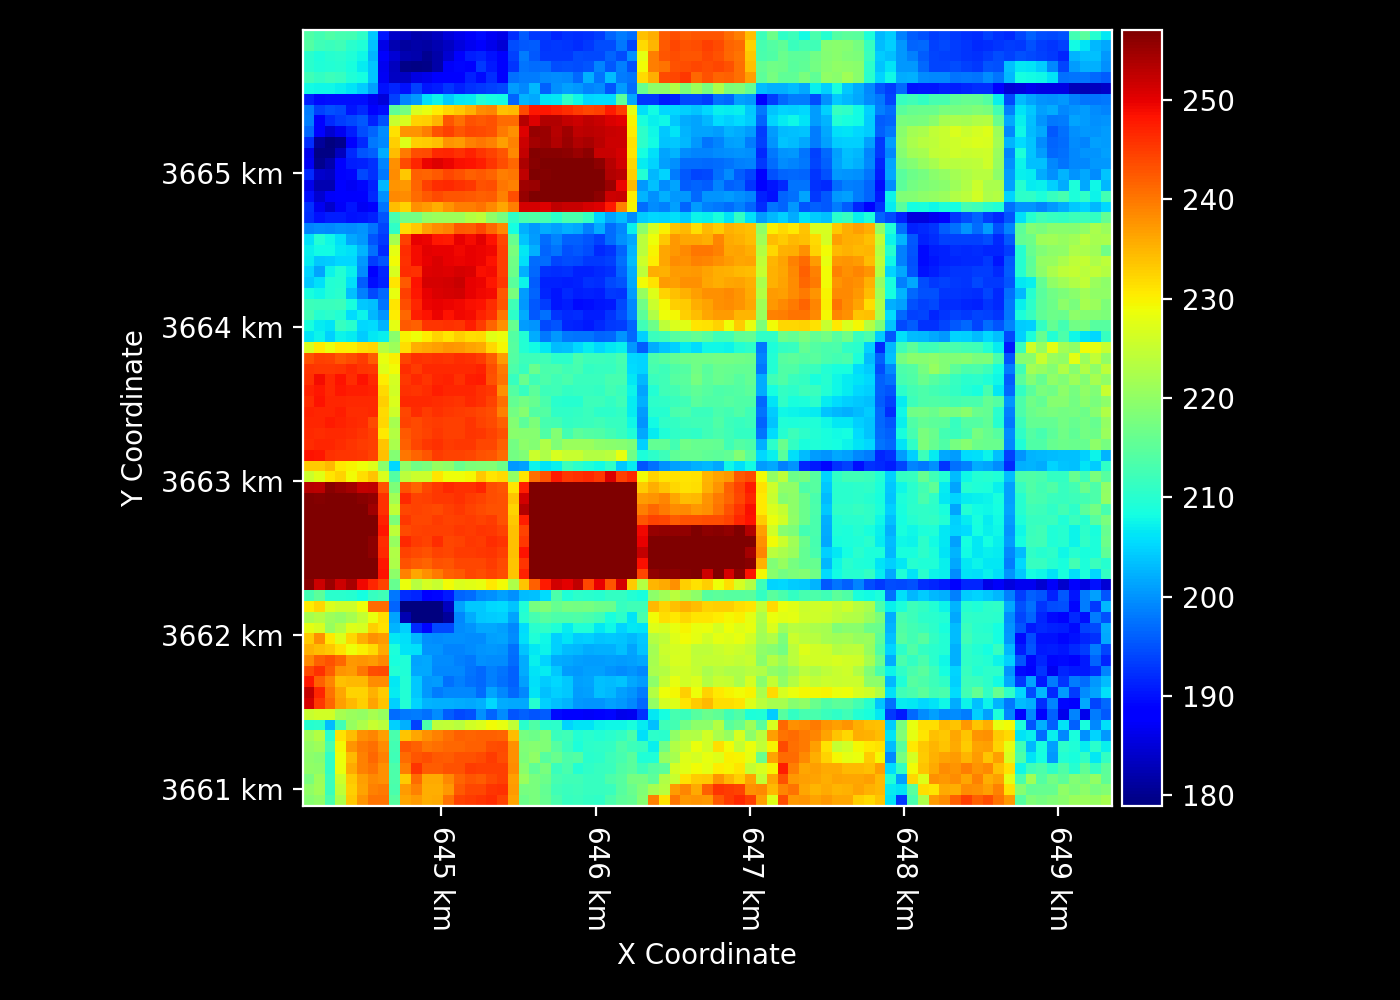

In [24]:
Rn_daily = daily_Rn_integration_verma(
    Rn=Rn,
    hour_of_day=hour_of_day,
    doy=day_of_year,
    lat=lat,
    sunrise_hour=sunrise_hour,
    daylight_hours=daylight_hours
)

Rn_daily

In [25]:
L3T_MET_granule = download_ECOSTRESS_granule(
    product="L3T_MET", 
    orbit=orbit,
    scene=scene,
    tile=tile, 
    aquisition_date=aquisition_date,
    parent_directory=ECOSTRESS_download_directory
)

L3T_MET_granule

/opt/homebrew/Caskroom/miniforge/base/envs/PTJPL/lib/python3.11/site-packages/pyproj/transformer.py:817: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(


L3TMET("/Users/halverso/Documents/ECOSTRESS/ET_sensitivity/ECOv002_L3T_MET_35698_014_11SPS_20241022T183627_0713_01")

/opt/homebrew/Caskroom/miniforge/base/envs/PTJPL/lib/python3.11/site-packages/rasters/raster.py:1740: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  plt.switch_backend(prior_backend)


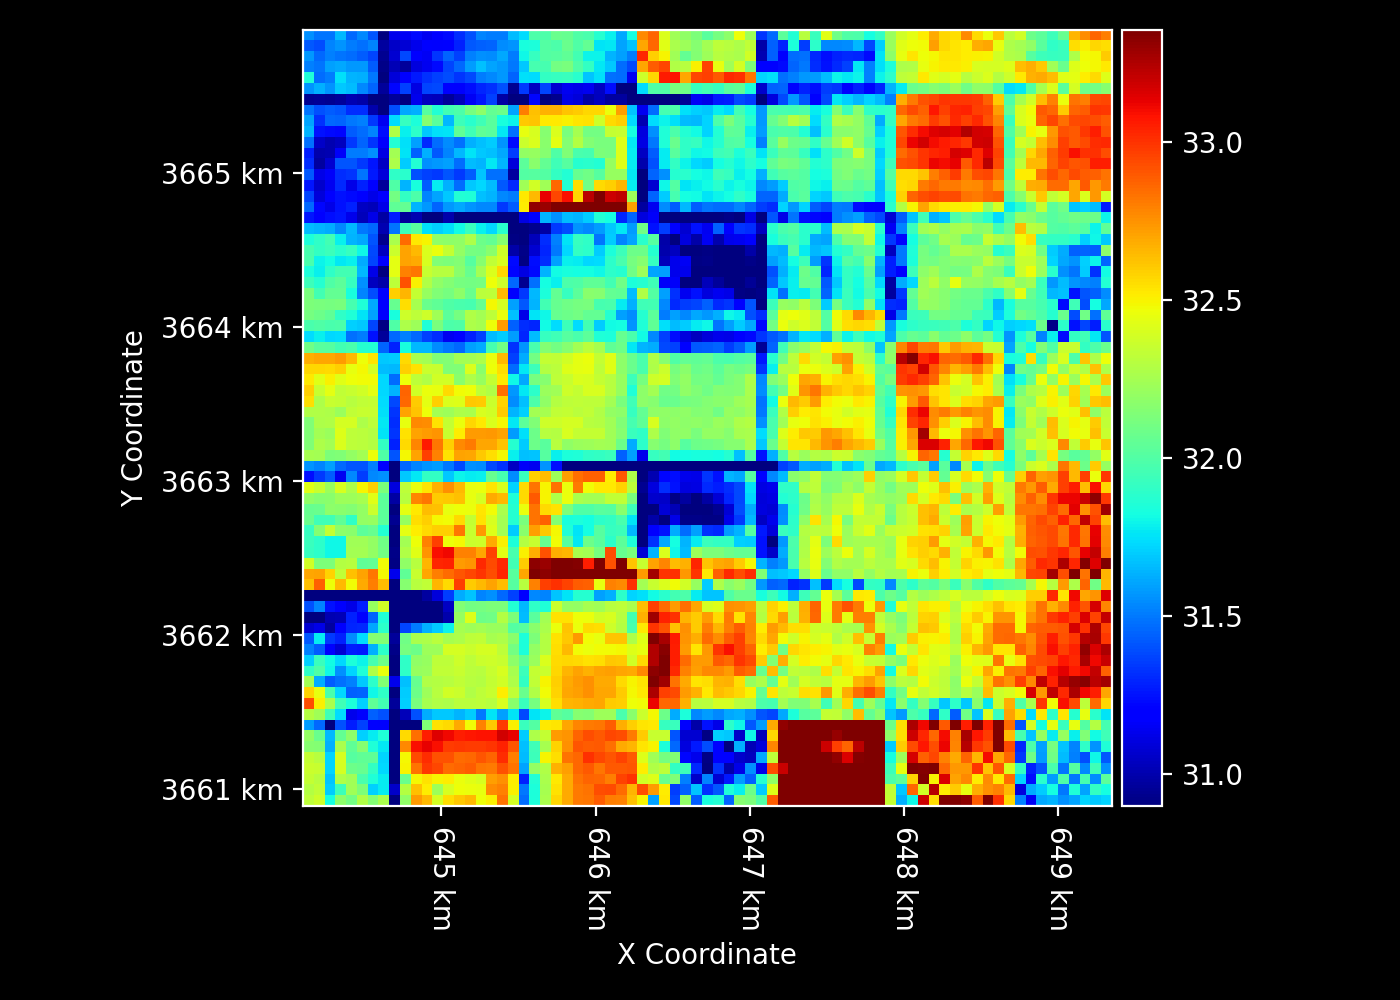

In [26]:
Ta_C = L3T_MET_granule.variable("Ta").to_geometry(geometry)
Ta_C

/opt/homebrew/Caskroom/miniforge/base/envs/PTJPL/lib/python3.11/site-packages/rasters/raster.py:1740: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  plt.switch_backend(prior_backend)


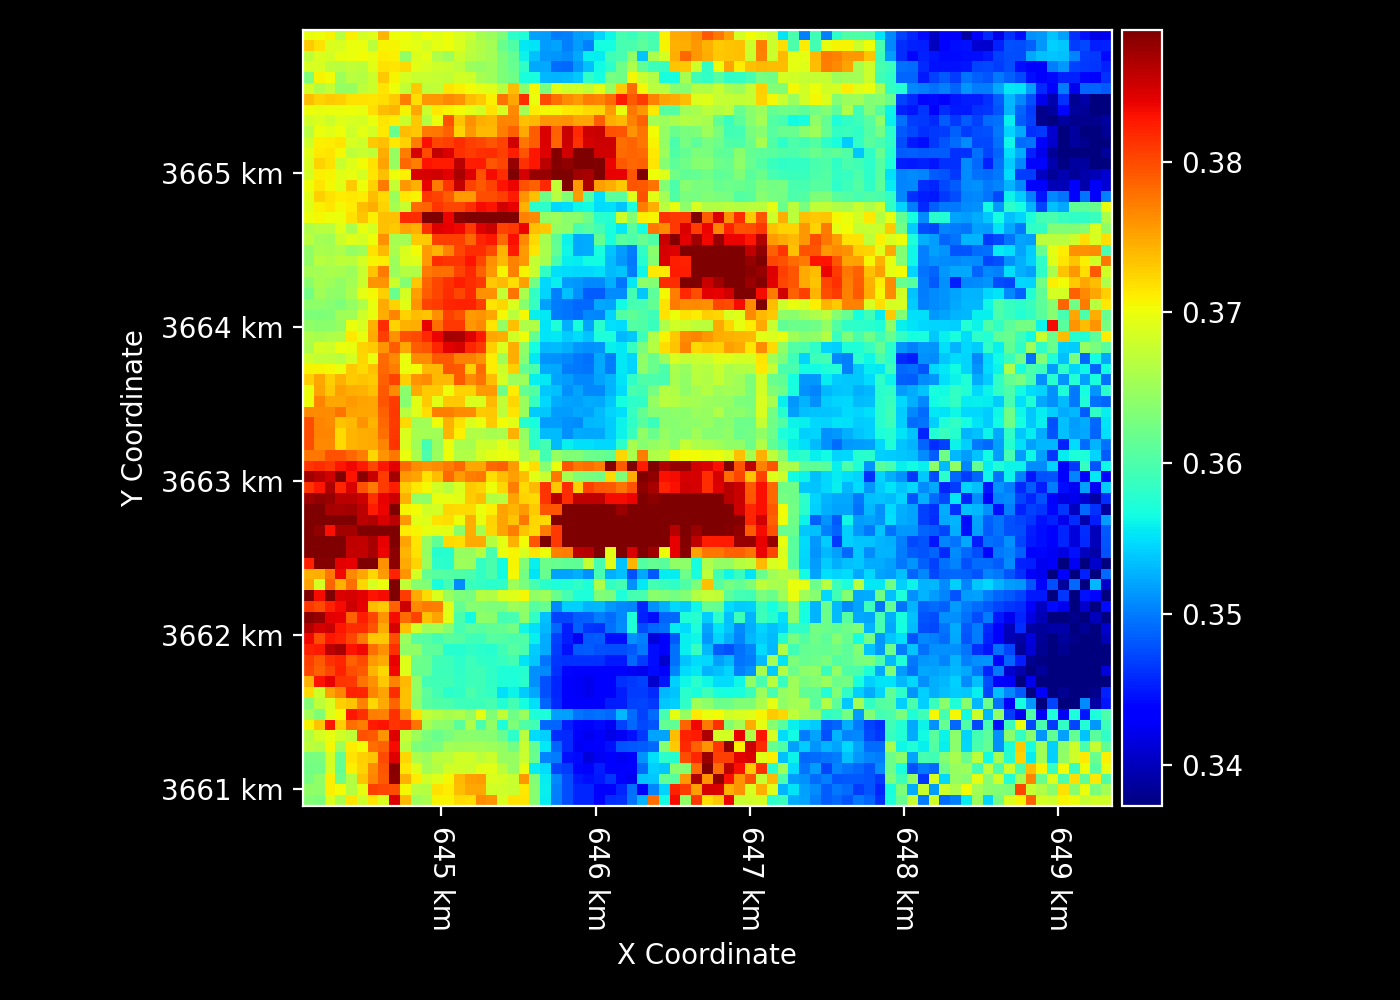

In [27]:
RH = L3T_MET_granule.variable("RH").to_geometry(geometry)
RH

/opt/homebrew/Caskroom/miniforge/base/envs/PTJPL/lib/python3.11/site-packages/rasters/raster.py:1740: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  plt.switch_backend(prior_backend)


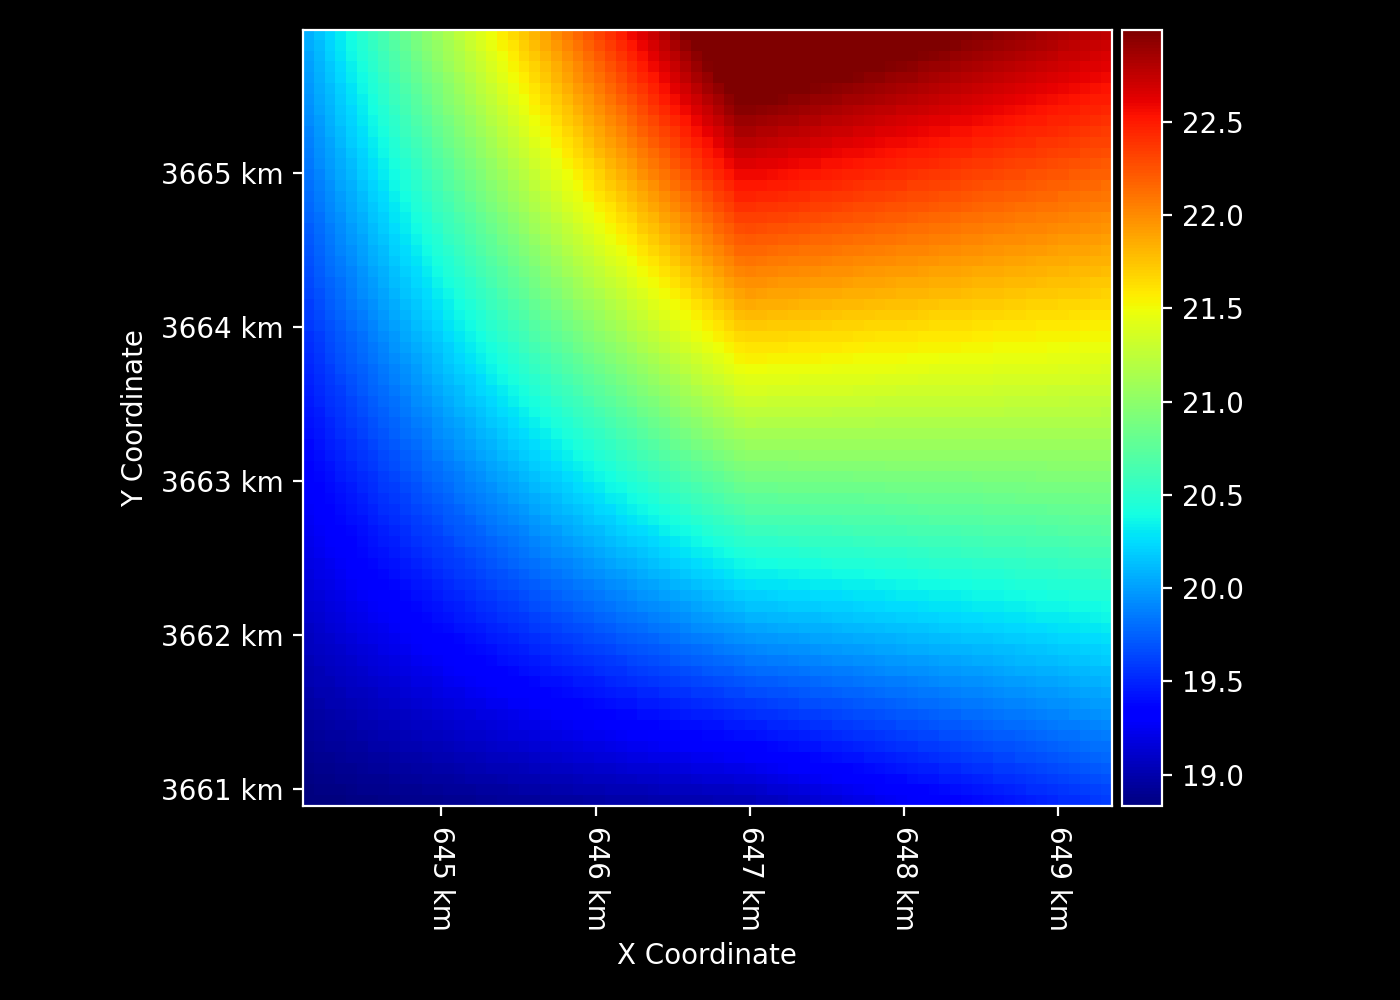

In [28]:
Topt = load_Topt(geometry)
Topt

/opt/homebrew/Caskroom/miniforge/base/envs/PTJPL/lib/python3.11/site-packages/rasters/raster.py:1740: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  plt.switch_backend(prior_backend)


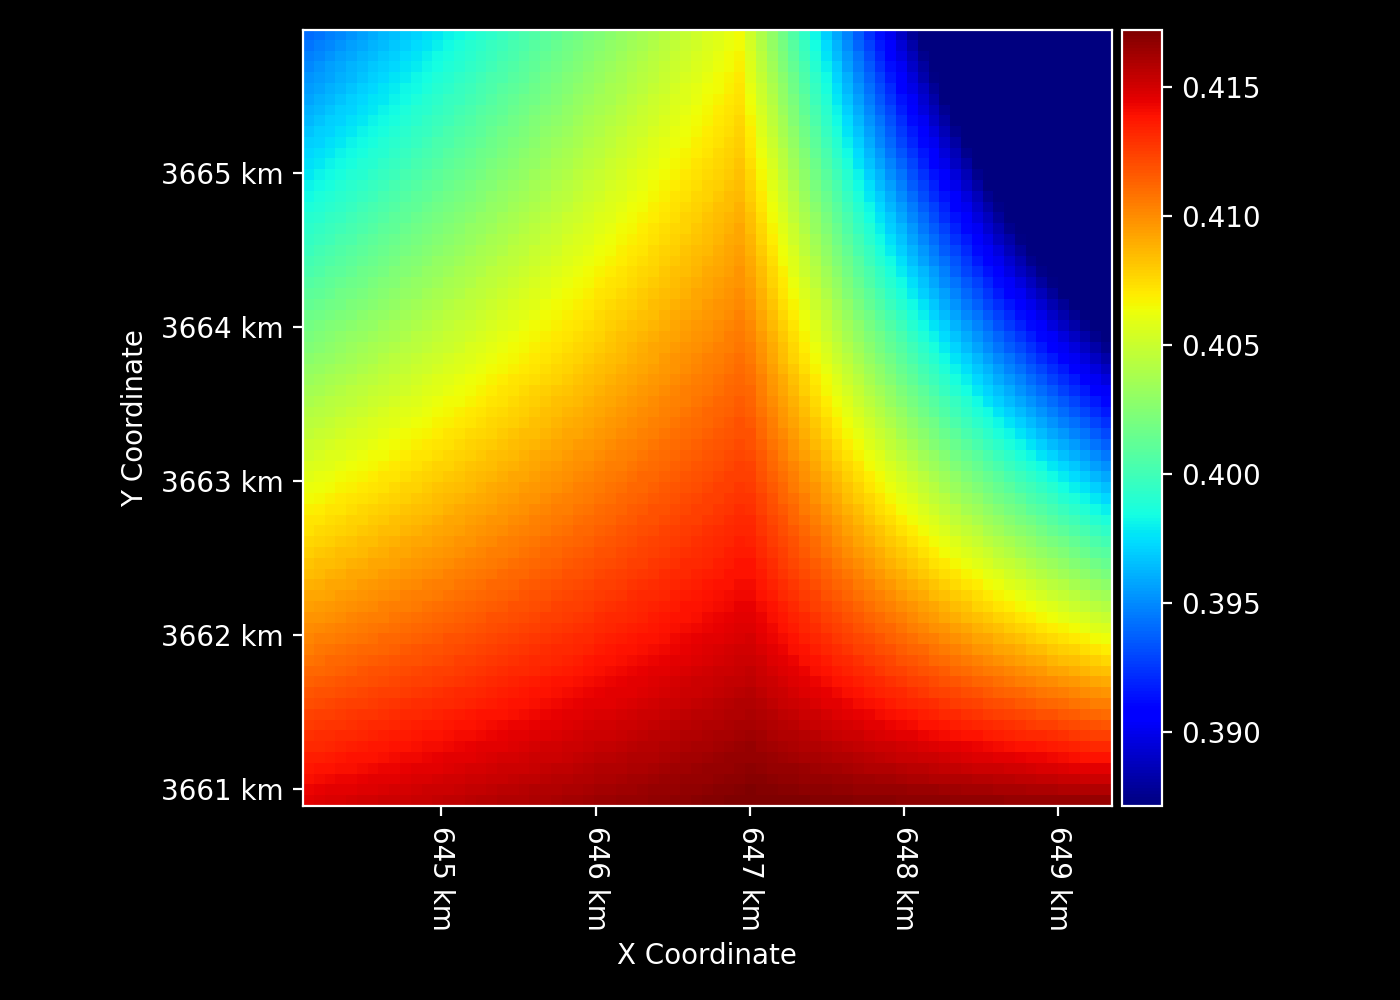

In [29]:
fAPARmax = load_fAPARmax(geometry)
fAPARmax

/Users/halverso/Projects/PT-JPL/PTJPL/meteorology_conversion/meteorology_conversion.py:92: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  SVP_kPa = np.clip(0.611 * np.exp((Ta_C * 17.27) / (Ta_C + 237.7)), 1, None)
/Users/halverso/Projects/PT-JPL/PTJPL/partitioning/fT.py:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.exp(-(((Ta_C - Topt) / Topt) ** 2))
/Users/halverso/Projects/PT-JPL/PTJPL/priestley_taylor/priestley_taylor.py:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return 4098 * (0.6108 * np.exp(17.27 * Ta_C / (237.7 + Ta_C))) / (Ta_C + 237.3) ** 2
/opt/homebrew/Caskroom/miniforge/base/envs/PTJPL/lib/python3.11/site-packages/numpy/_core/_methods.py:117: DeprecationWarning: __array_wrap__ must a

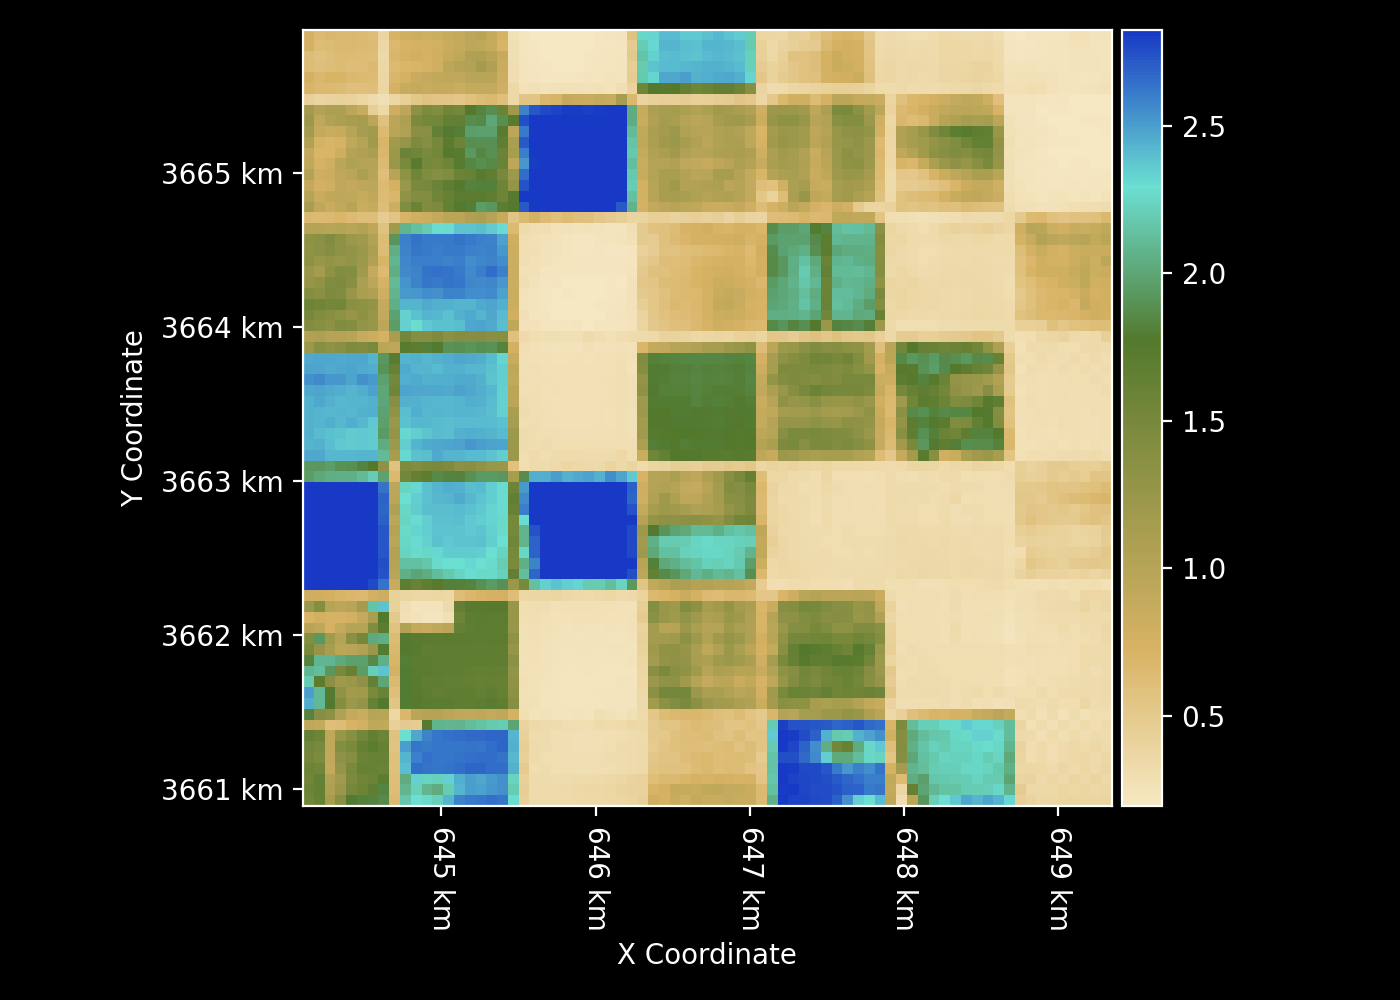

In [30]:
results = PTJPL(
    NDVI=NDVI,
    Ta_C=Ta_C,
    RH=RH,
    Rn=Rn,
    albedo=albedo,
    ST_C=ST_C
)

LE = results["LE"]
EF = rt.where((LE == 0) | (Rn == 0), 0, LE / Rn)
LE_daily = rt.clip(EF * Rn_daily, 0, None) 
LATENT_VAPORIZATION_JOULES_PER_KILOGRAM = 2450000.0
ET_daily_mm = np.clip(LE_daily * daylight_seconds / LATENT_VAPORIZATION_JOULES_PER_KILOGRAM, 0, None)
ET_daily_mm.cmap = ET_COLORMAP
ET_daily_mm

In [31]:
shifted_tile_geometry = tile_geometry.shift_distance(70, 45)
shifted_tile_geometry

{
  "dimensions": {
    "rows": 1568,
    "cols": 1568
  },
  "bbox": {
    "xmin": 600049.4974746831,
    "ymin": 3590210.502525317,
    "xmax": 709809.4974746831,
    "ymax": 3699970.502525317
  },
  "crs": "EPSG:32611",
  "resolution": {
    "cell_width": 70.0,
    "cell_height": -70.0
  }
}

/opt/homebrew/Caskroom/miniforge/base/envs/PTJPL/lib/python3.11/site-packages/rasters/raster.py:1740: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  plt.switch_backend(prior_backend)


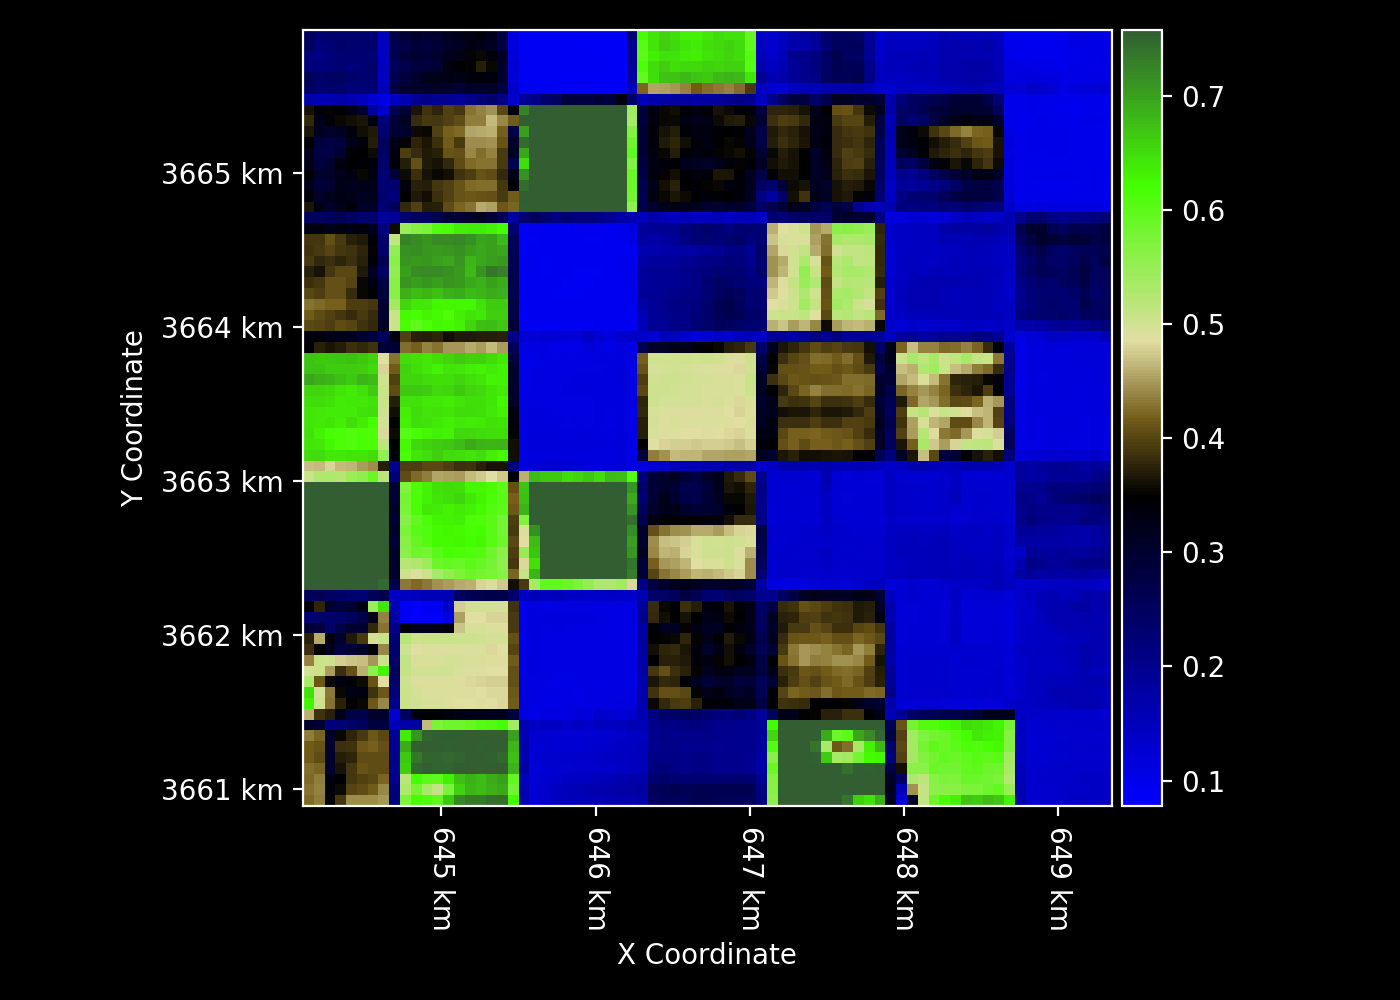

In [32]:
NDVI

/opt/homebrew/Caskroom/miniforge/base/envs/PTJPL/lib/python3.11/site-packages/rasters/raster.py:1740: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  plt.switch_backend(prior_backend)


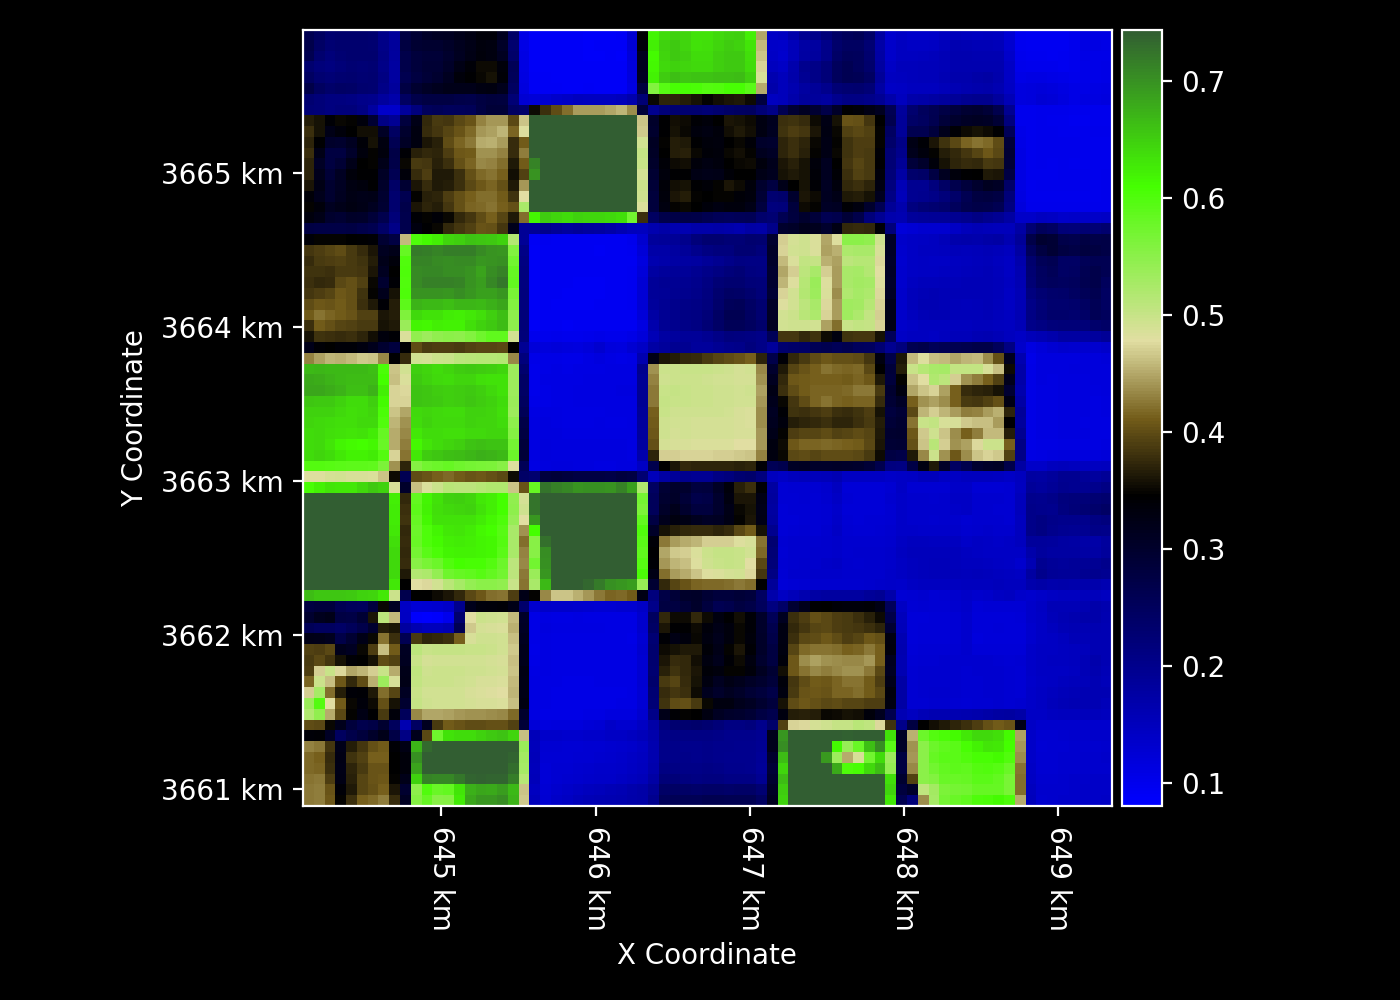

In [33]:
shifted_NDVI_tile = rt.Raster(NDVI_tile, geometry=shifted_tile_geometry)
shifted_NDVI = shifted_NDVI_tile.to_geometry(geometry, resampling="linear")
shifted_NDVI.cmap = NDVI_COLORMAP
shifted_NDVI

/opt/homebrew/Caskroom/miniforge/base/envs/PTJPL/lib/python3.11/site-packages/rasters/raster.py:1740: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  plt.switch_backend(prior_backend)


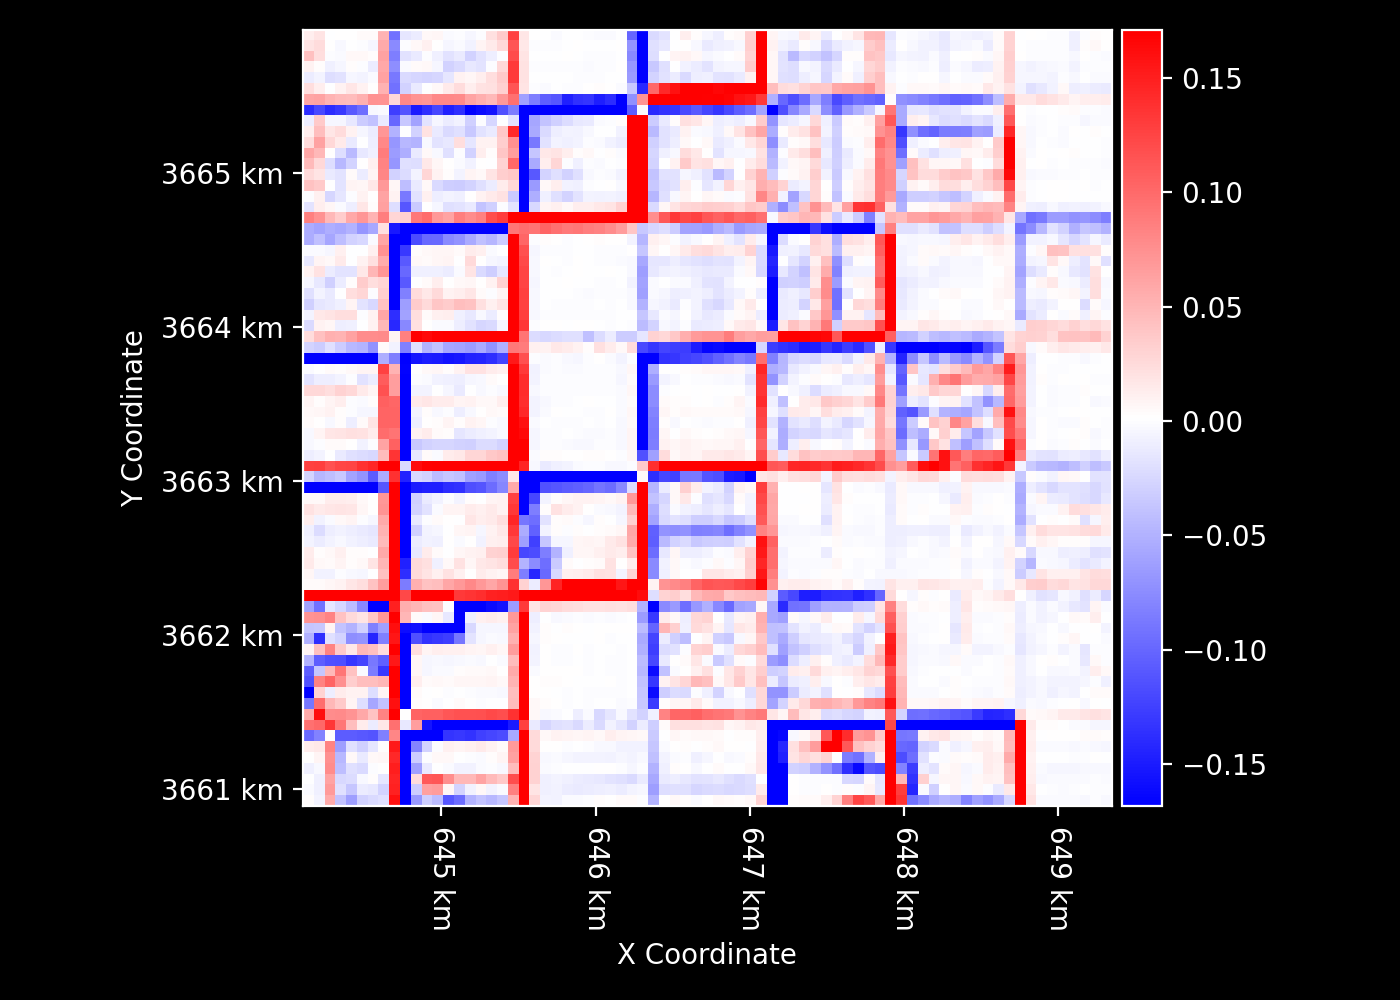

In [34]:
NDVI_error = shifted_NDVI - NDVI
NDVI_error.cmap = error_cmap
NDVI_error

/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_68573/690071977.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  NDVI_abs_error = np.abs(shifted_NDVI - NDVI)
/opt/homebrew/Caskroom/miniforge/base/envs/PTJPL/lib/python3.11/site-packages/rasters/raster.py:1740: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  plt.switch_backend(prior_backend)


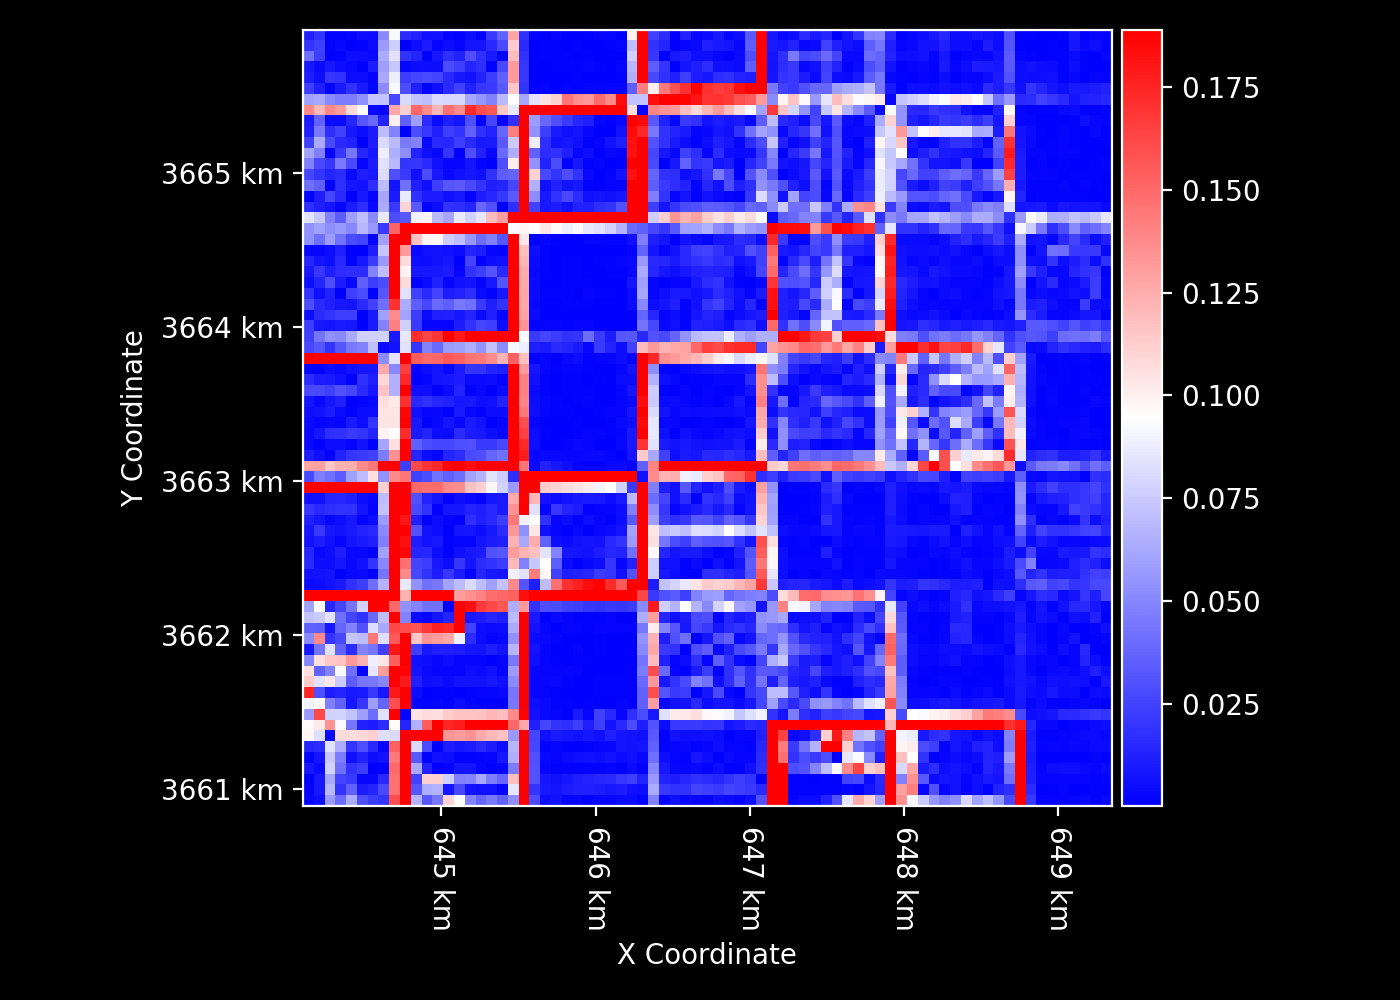

In [35]:
NDVI_abs_error = np.abs(shifted_NDVI - NDVI)
NDVI_abs_error.cmap = error_cmap
NDVI_abs_error

/opt/homebrew/Caskroom/miniforge/base/envs/PTJPL/lib/python3.11/site-packages/rasters/raster.py:1740: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  plt.switch_backend(prior_backend)


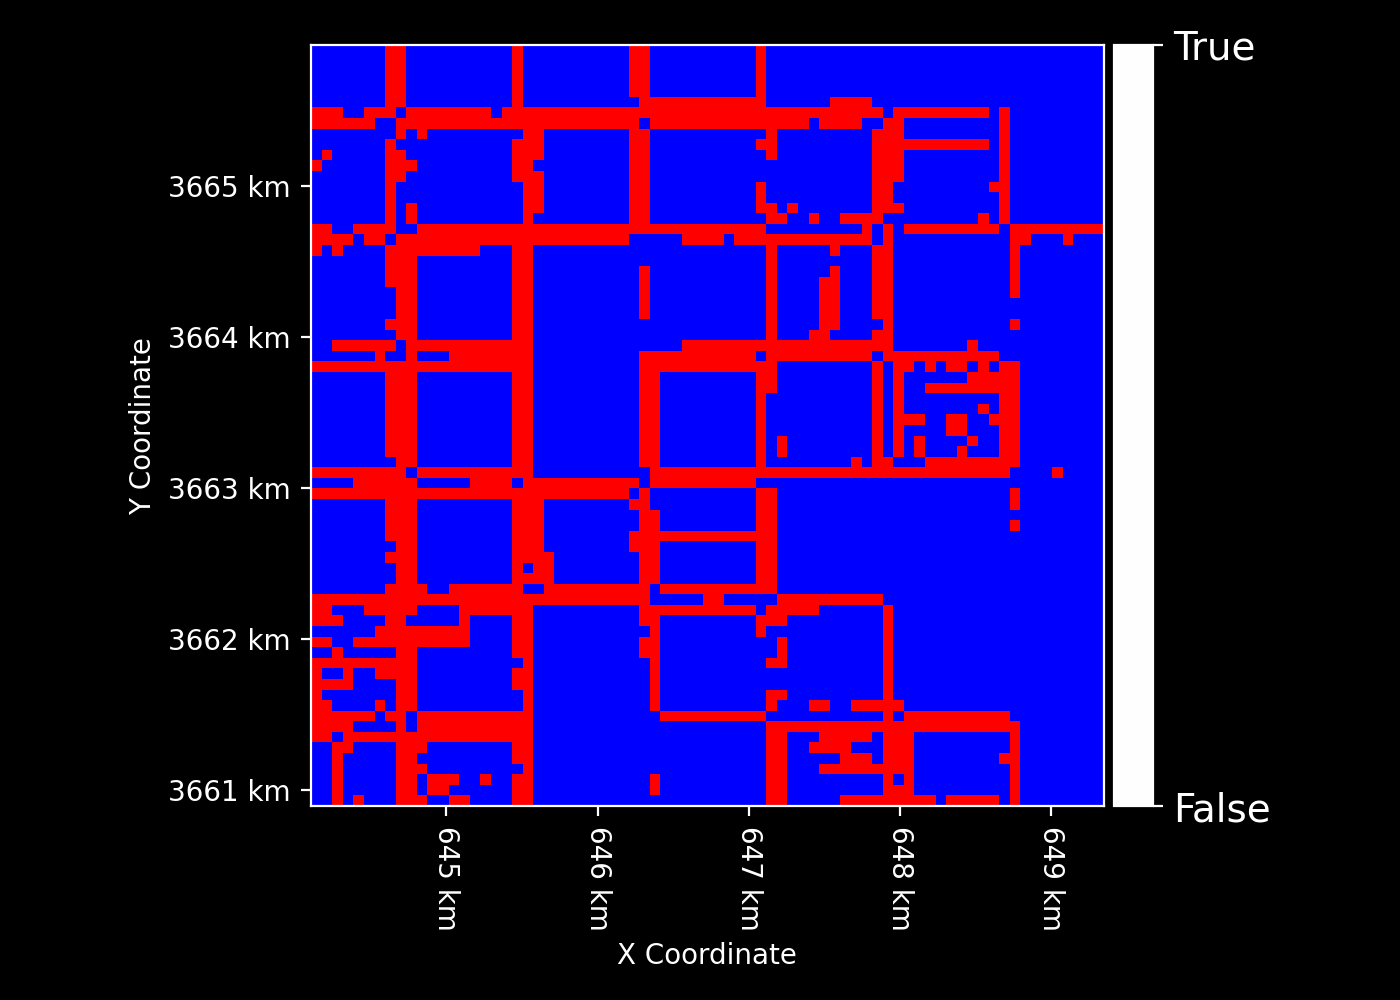

In [36]:
NDVI_abs_error > 0.05 ### use 0.05 as a segmentation threshold

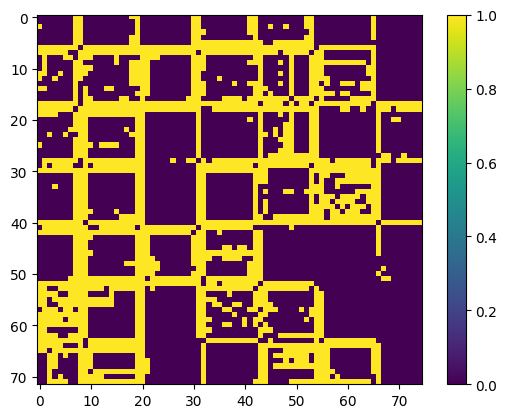

In [37]:
X = np.array(NDVI_abs_error).reshape(np.prod(NDVI_error.shape),1)
gm = GaussianMixture(n_components=2, random_state=0).fit(X)
clss = gm.predict(X)
plt.imshow(clss.reshape(NDVI_error.shape))
plt.colorbar()

/Users/halverso/Projects/PT-JPL/PTJPL/meteorology_conversion/meteorology_conversion.py:92: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  SVP_kPa = np.clip(0.611 * np.exp((Ta_C * 17.27) / (Ta_C + 237.7)), 1, None)
/Users/halverso/Projects/PT-JPL/PTJPL/partitioning/fT.py:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.exp(-(((Ta_C - Topt) / Topt) ** 2))
/Users/halverso/Projects/PT-JPL/PTJPL/priestley_taylor/priestley_taylor.py:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return 4098 * (0.6108 * np.exp(17.27 * Ta_C / (237.7 + Ta_C))) / (Ta_C + 237.3) ** 2
/opt/homebrew/Caskroom/miniforge/base/envs/PTJPL/lib/python3.11/site-packages/numpy/_core/_methods.py:117: DeprecationWarning: __array_wrap__ must a

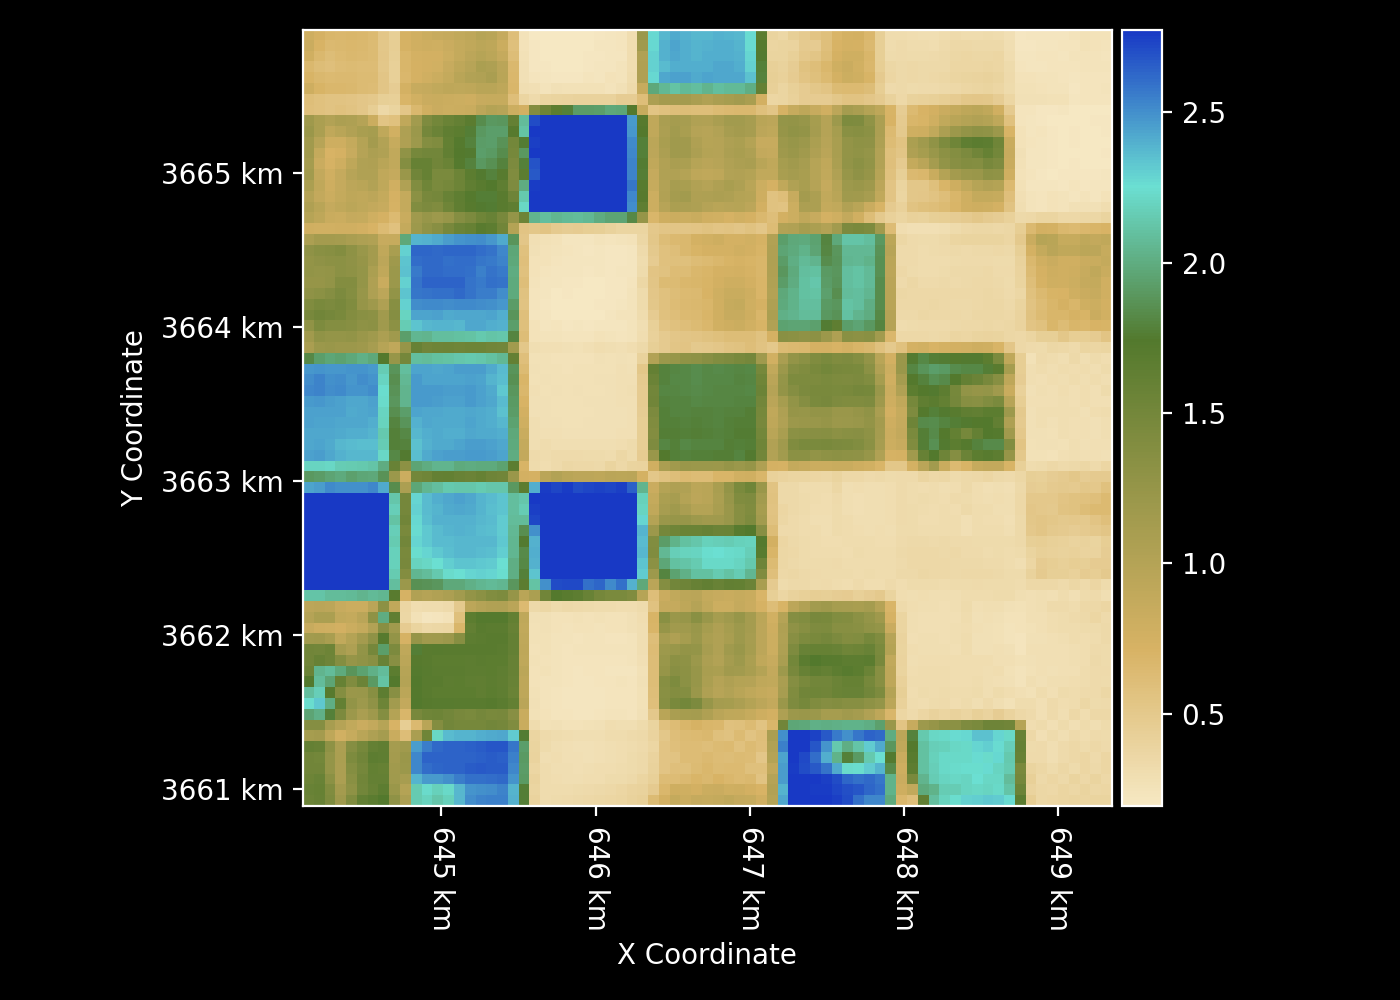

In [38]:
shifted_results = PTJPL(
    NDVI=shifted_NDVI,
    Ta_C=Ta_C,
    RH=RH,
    Rn=Rn,
    albedo=albedo,
    ST_C=ST_C
)

shifted_LE = shifted_results["LE"]
shifted_EF = rt.where((shifted_LE == 0) | (Rn == 0), 0, shifted_LE / Rn)
shifted_LE_daily = rt.clip(shifted_EF * Rn_daily, 0, None) 
LATENT_VAPORIZATION_JOULES_PER_KILOGRAM = 2450000.0
shifted_ET_daily_mm = np.clip(shifted_LE_daily * daylight_seconds / LATENT_VAPORIZATION_JOULES_PER_KILOGRAM, 0, None)
shifted_ET_daily_mm.cmap = ET_COLORMAP
shifted_ET_daily_mm

/opt/homebrew/Caskroom/miniforge/base/envs/PTJPL/lib/python3.11/site-packages/rasters/raster.py:1740: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  plt.switch_backend(prior_backend)


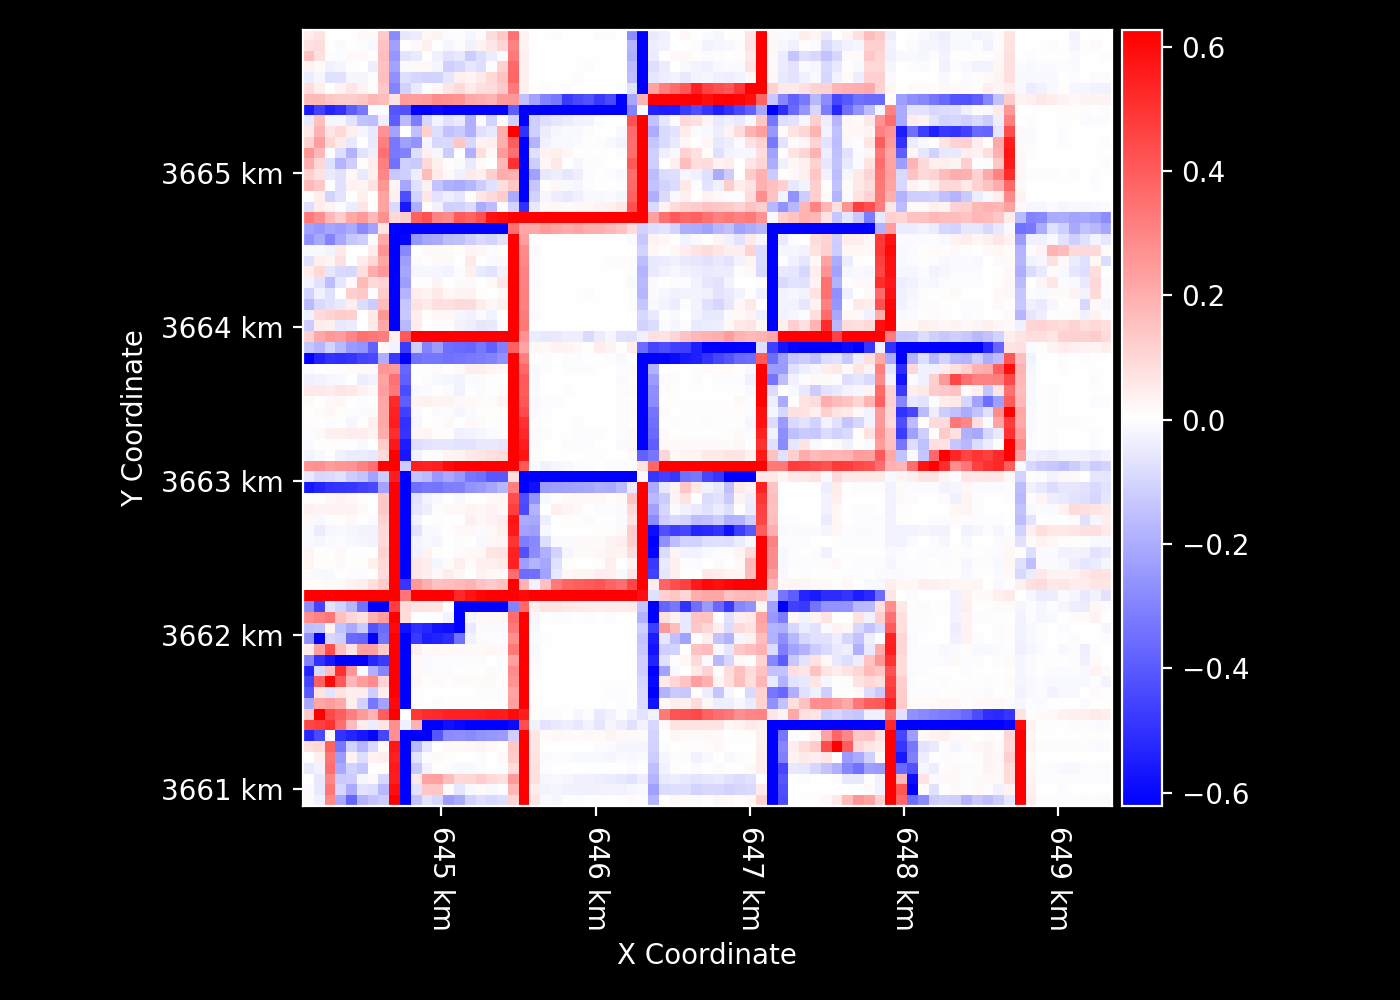

In [61]:
shifted_ET_daily_mm_error = shifted_ET_daily_mm - ET_daily_mm
shifted_ET_daily_mm_error.cmap = error_cmap
shifted_ET_daily_mm_error

/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_68573/934391110.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ET_daily_mm_abs_error = np.abs(shifted_ET_daily_mm - ET_daily_mm)
/opt/homebrew/Caskroom/miniforge/base/envs/PTJPL/lib/python3.11/site-packages/rasters/raster.py:1740: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  plt.switch_backend(prior_backend)


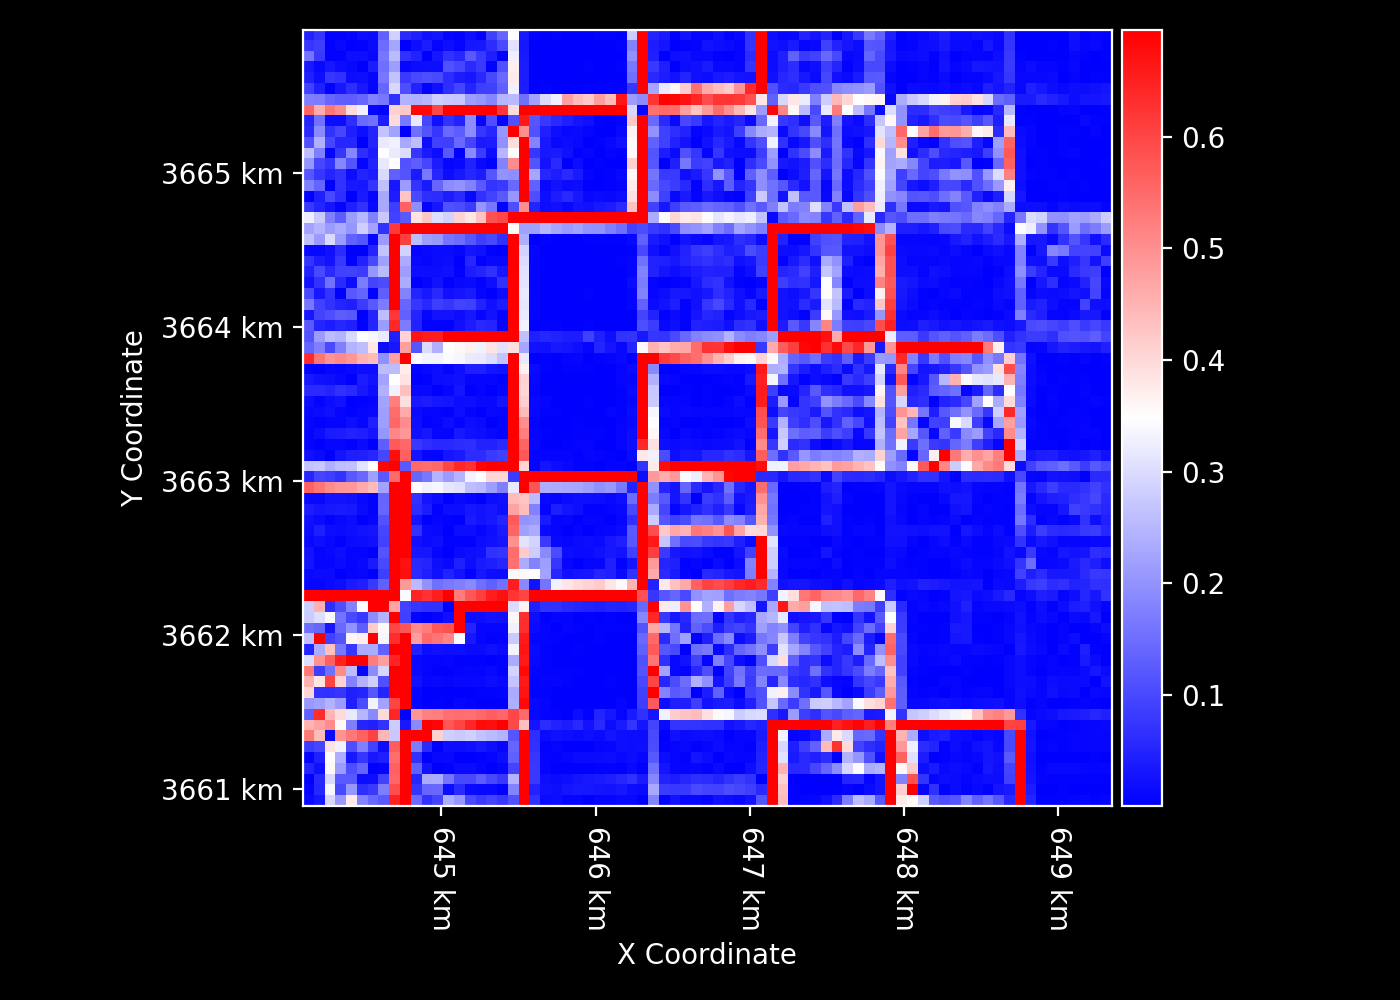

In [62]:
ET_daily_mm_abs_error = np.abs(shifted_ET_daily_mm - ET_daily_mm)
ET_daily_mm_abs_error.cmap = error_cmap
ET_daily_mm_abs_error

In [64]:
# LE_abs_error > 15 ## 15 W/m^2

/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_68573/21144126.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  NDVI_abs_error = np.abs(shifted_NDVI - NDVI)
/opt/homebrew/Caskroom/miniforge/base/envs/PTJPL/lib/python3.11/site-packages/rasters/raster.py:1740: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  plt.switch_backend(prior_backend)


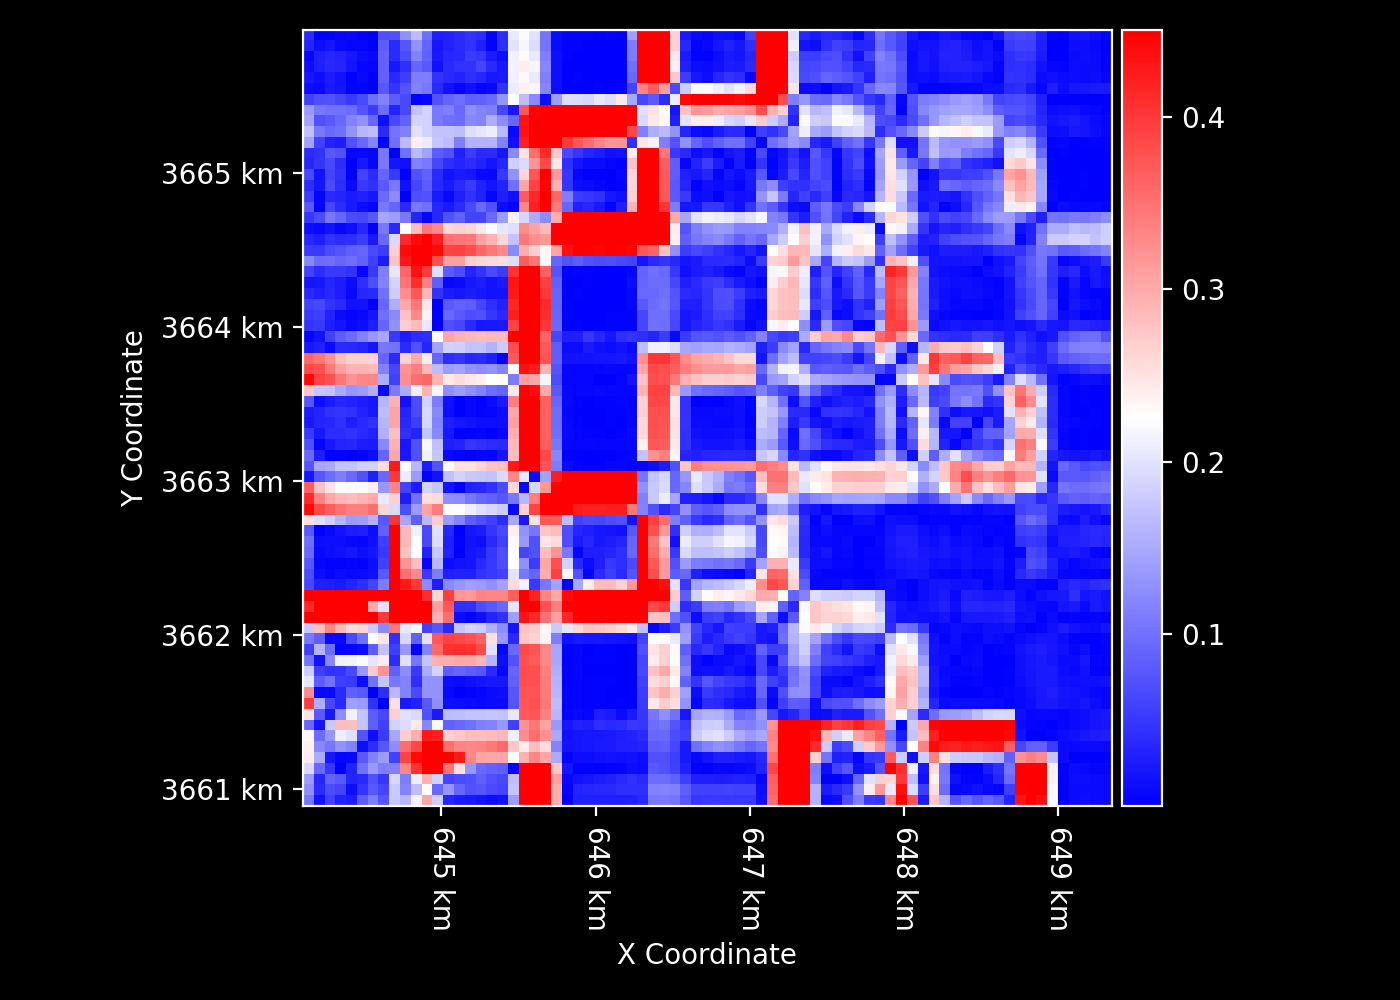

In [65]:
shifted_tile_geometry = tile_geometry.shift_distance(350, 45)
shifted_NDVI_tile = rt.Raster(NDVI_tile, geometry=shifted_tile_geometry)
shifted_NDVI = shifted_NDVI_tile.to_geometry(geometry, resampling="linear")
shifted_NDVI.cmap = NDVI_COLORMAP

NDVI_abs_error = np.abs(shifted_NDVI - NDVI)
NDVI_abs_error.cmap = error_cmap
NDVI_abs_error ### use 0.05 as a segmentation threshold

/opt/homebrew/Caskroom/miniforge/base/envs/PTJPL/lib/python3.11/site-packages/rasters/raster.py:1740: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  plt.switch_backend(prior_backend)


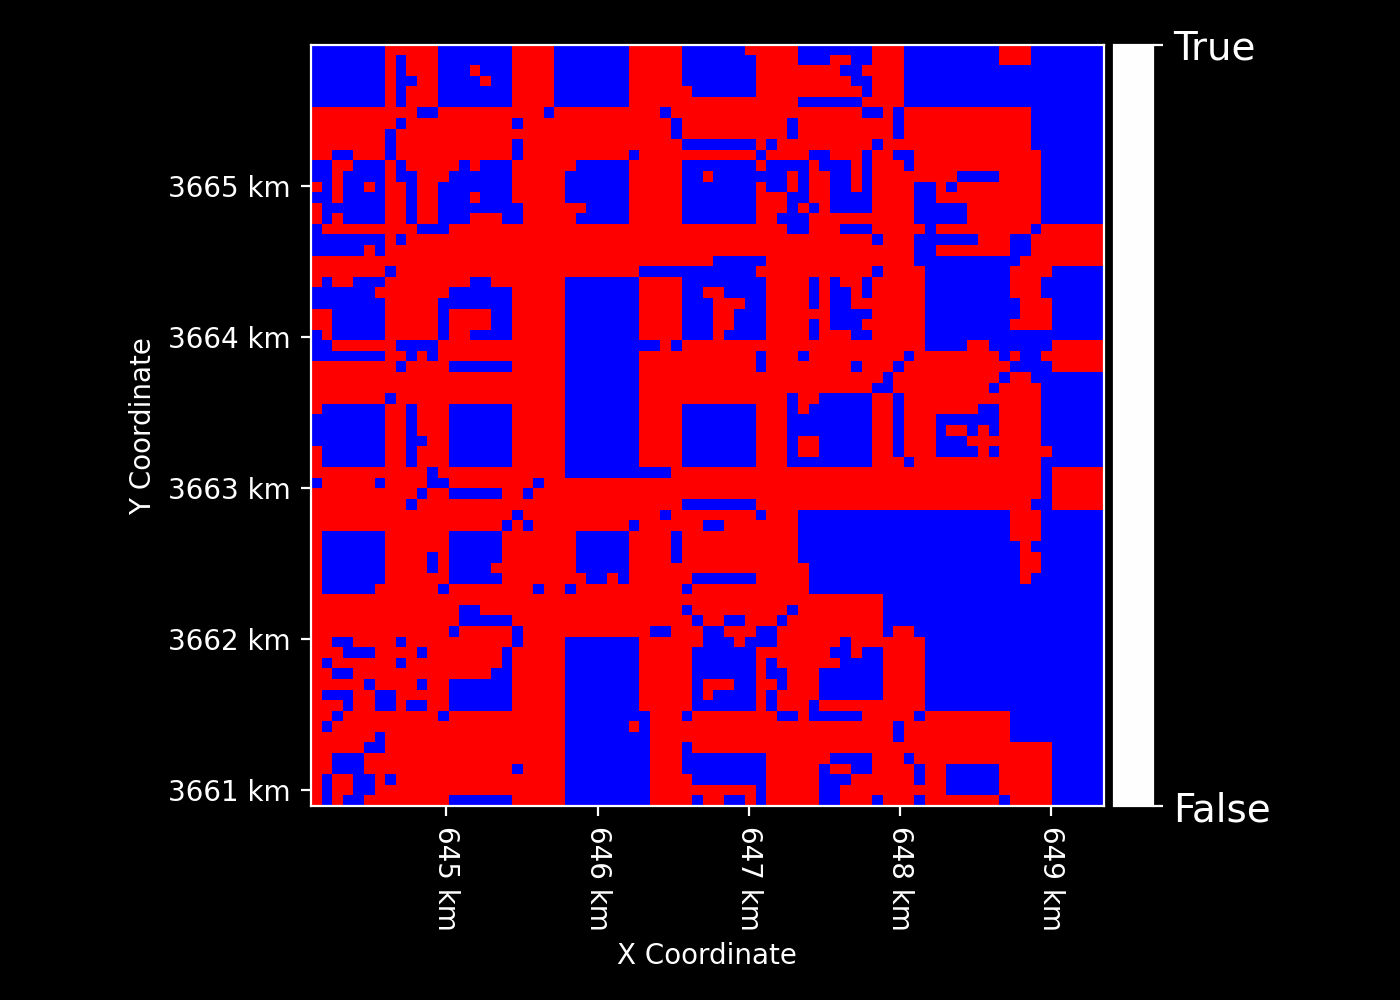

In [66]:
NDVI_abs_error > 0.05

In [68]:
n=200

In [69]:
directions = np.random.uniform(0, 360, n)
# directions

In [70]:
min_distance = 0
max_distance = 5 * 70
min_distance, max_distance

(0, 350)

In [71]:
distances = np.random.uniform(min_distance, max_distance, n)
# distances

In [72]:
ng = np.sqrt(1 - 0.8**2) ## acceptable ET error

In [87]:
df = pd.DataFrame({
    "distance": [],
    "direction": [],
    "num_higherror": [],
    "NDVI_error": [],
    "NDVI_hetero_error": [],
    "NDVI_homo_error": [],
    "ET_error": [],
    "ET_hetero_error": [],
    "ET_homo_error": [],
    "NDVI": [],
    "ET": []
})

for distance, direction in zip(distances, directions):
    shifted_tile_geometry = tile_geometry.shift_distance(distance, direction)
    shifted_NDVI_tile = rt.Raster(NDVI_tile, geometry=shifted_tile_geometry)
    shifted_NDVI = shifted_NDVI_tile.to_geometry(geometry, resampling="linear")

    NDVI_error = shifted_NDVI - NDVI
    
    shifted_results = PTJPL(
        NDVI=shifted_NDVI,
        Ta_C=Ta_C,
        RH=RH,
        Rn=Rn,
        albedo=albedo,
        ST_C=ST_C
    )

    shifted_LE = shifted_results["LE"]
    shifted_EF = rt.where((shifted_LE == 0) | (Rn == 0), 0, shifted_LE / Rn)
    shifted_LE_daily = rt.clip(shifted_EF * Rn_daily, 0, None) 
    LATENT_VAPORIZATION_JOULES_PER_KILOGRAM = 2450000.0
    shifted_ET_daily_mm = np.clip(shifted_LE_daily * daylight_seconds / LATENT_VAPORIZATION_JOULES_PER_KILOGRAM, 0, None)
    shifted_ET_daily_mm_error = shifted_ET_daily_mm - ET_daily_mm

    ## add field boarder errors
    ## number of pixels with large errors
    kp = np.abs(NDVI_error) > 0.05
    np_large = np.sum(kp)

    df = pd.concat([df, pd.DataFrame({
        "distance": [distance],
        "direction": [direction],
        "num_higherror": [np_large],
        "NDVI_error": [np.nanmean(np.abs(NDVI_error))],
        "NDVI_hetero_error": [np.nanmean(np.abs(NDVI_error[kp]))],
        "NDVI_homo_error": [np.nanmean(np.abs(NDVI_error[~kp]))],
        "ET_error": [np.nanmean(np.abs(shifted_ET_daily_mm_error))],
        "ET_hetero_error": [np.nanmean(np.abs(shifted_ET_daily_mm_error[kp]))],
        "ET_homo_error": [np.nanmean(np.abs(shifted_ET_daily_mm_error[~kp]))],
        "NDVI": [np.nanmean(NDVI)],
        "ET": [np.nanmean(ET_daily_mm)]
    })])

df

/Users/halverso/Projects/PT-JPL/PTJPL/meteorology_conversion/meteorology_conversion.py:92: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  SVP_kPa = np.clip(0.611 * np.exp((Ta_C * 17.27) / (Ta_C + 237.7)), 1, None)
/Users/halverso/Projects/PT-JPL/PTJPL/partitioning/fT.py:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.exp(-(((Ta_C - Topt) / Topt) ** 2))
/Users/halverso/Projects/PT-JPL/PTJPL/priestley_taylor/priestley_taylor.py:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return 4098 * (0.6108 * np.exp(17.27 * Ta_C / (237.7 + Ta_C))) / (Ta_C + 237.3) ** 2
/opt/homebrew/Caskroom/miniforge/base/envs/PTJPL/lib/python3.11/site-packages/numpy/_core/_methods.py:117: DeprecationWarning: __array_wrap__ must a

distance   direction  num_higherror  NDVI_error  NDVI_hetero_error  \
0    20.842232  332.088599          358.0    0.013085           0.079728   
0    81.716893   43.574196         1521.0    0.052525           0.154677   
0    89.324718  141.736428         1586.0    0.056214           0.161206   
0   327.846137   60.509707         2936.0    0.129051           0.222874   
0    26.652719  218.387642          558.0    0.017117           0.085561   
..         ...         ...            ...         ...                ...   
0   308.151799  258.699868         2753.0    0.117660           0.213973   
0   155.618105  329.693521         2177.0    0.083625           0.186133   
0   115.796014   45.869671         1821.0    0.066739           0.170693   
0    25.519648   27.792661          475.0    0.015943           0.087625   
0   205.572184  244.209016         2371.0    0.094050           0.193765   

    NDVI_homo_error  ET_error  ET_hetero_error  ET_homo_error      NDVI  \
0          0.008353  0.045766         0.270383       0.029818  0.335572   
0          0.012469  0.188966         0.560214       0.043396  0.335572   
0          0.012555  0.202536         0.584499       0.043701  0.335572   
0          0.017255  0.460424         0.798999       0.056992  0.335572   
0          0.009229  0.059817         0.296987       0.032486  0.335572   
..              ...       ...              ...            ...       ...   
0          0.017490  0.420438         0.769944       0.056935  0.335572   
0          0.014385  0.297932         0.665938       0.049359  0.335572   
0          0.013846  0.237489         0.610239       0.047834  0.335572   
0          0.009030  0.055755         0.298667       0.032327  0.335572   
0          0.015997  0.335369         0.695304       0.053624  0.335572   

          ET  
0   1.131109  
0   1.131109  
0   1.131109  
0   1.131109  
0   1.131109  
..       ...  
0   1.131109  
0   1.131109  
0   1.131109  
0   1.131109  
0   1.131109  

[200 rows x 11 columns]

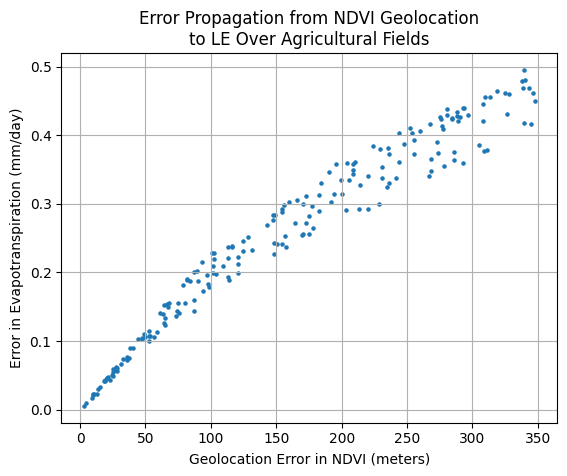

In [89]:
plt.scatter(x=df.distance, y=df.ET_error, s=5)
plt.xlabel('Geolocation Error in NDVI (meters)')
plt.ylabel('Error in Evapotranspiration (mm/day)')
plt.title("Error Propagation from NDVI Geolocation\nto LE Over Agricultural Fields")
plt.grid(True)

plt.savefig("Error Propagation from NDVI Geolocation to PT-JPL Latent Heat Flux Over Agricultural Fields.png", bbox_inches="tight")

plt.show()

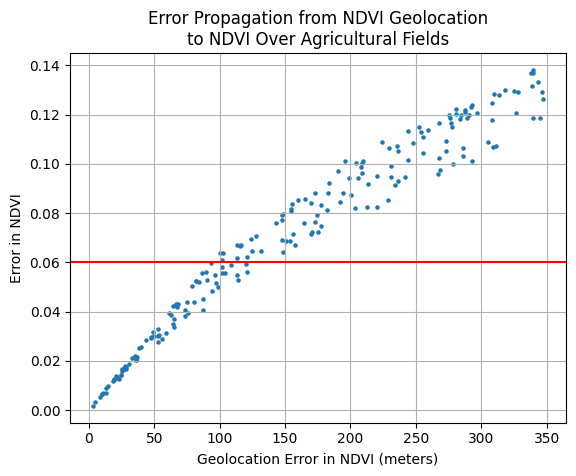

In [90]:
ndvi_errorcutoff = np.sqrt(0.1**2 - 0.08**2)

plt.scatter(x=df.distance, y=df.NDVI_error, s=5)
plt.axhline(y=ndvi_errorcutoff, color='red', linestyle='-')

plt.xlabel('Geolocation Error in NDVI (meters)')
plt.ylabel('Error in NDVI')
plt.title("Error Propagation from NDVI Geolocation\nto NDVI Over Agricultural Fields")
plt.grid(True)

# plt.savefig("Error Propagation from NDVI Geolocation to NDVI Over Agricultural Fields.png", bbox_inches="tight")

plt.show()

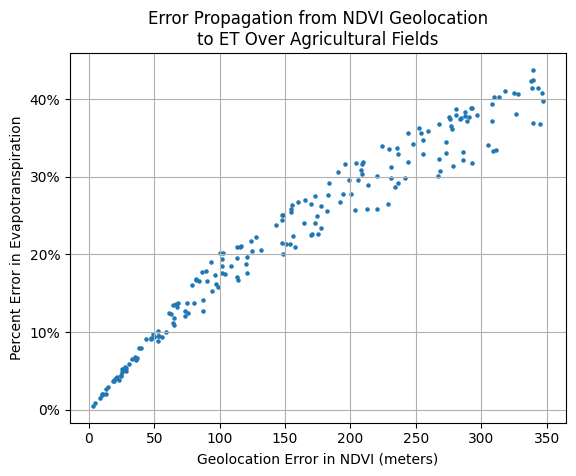

In [91]:
plt.scatter(x=df.distance, y=(df.ET_error / df.ET * 100), s=5)
plt.xlabel('Geolocation Error in NDVI (meters)')
plt.ylabel('Percent Error in Evapotranspiration')
plt.title("Error Propagation from NDVI Geolocation\nto ET Over Agricultural Fields")
plt.grid(True)

# Function to format y-axis labels with percent sign
def percent_formatter(x, pos):
    return f'{x:.0f}%'

plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))

plt.savefig("Error Propagation from NDVI Geolocation to PT-JPL Evapotranspiration Over Agricultural Fields.png", bbox_inches="tight")

plt.show()

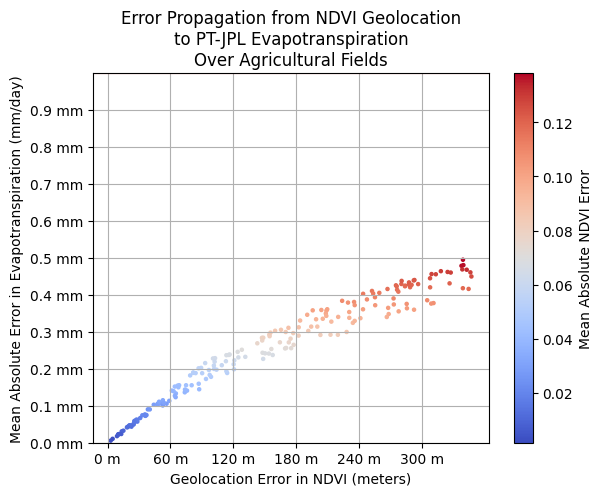

In [99]:
scatter = plt.scatter(x=df.distance, y=df.ET_error, c=df.NDVI_error, s=5, cmap='coolwarm')
plt.xlabel('Geolocation Error in NDVI (meters)')
plt.ylabel('Mean Absolute Error in Evapotranspiration (mm/day)')
plt.title("Error Propagation from NDVI Geolocation\nto PT-JPL Evapotranspiration\nOver Agricultural Fields")
plt.grid(True)

# Set y-axis ticks interval to 0.1 and label them with "mm"
y_ticks = np.arange(0, 1, 0.1)
plt.ylim(0, 1)
plt.yticks(y_ticks, [f'{tick:.1f} mm' for tick in y_ticks])

# Set x-axis ticks interval to 60 and format them as integers
x_ticks = np.arange(0, 360, 60)
plt.xticks(x_ticks, [f'{int(tick)} m' for tick in x_ticks])

# Add horizontal red lines at y=1 and y=-1
plt.axhline(y=1, color='red', linestyle='-')
# plt.axhline(y=-1, color='red', linestyle='-')

# Show color bar legend
plt.colorbar(scatter, label='Mean Absolute NDVI Error')

plt.savefig("Error Propagation from NDVI Geolocation to PT-JPL Evapotranspiration Over Agricultural Fields.png", bbox_inches="tight")

plt.show()

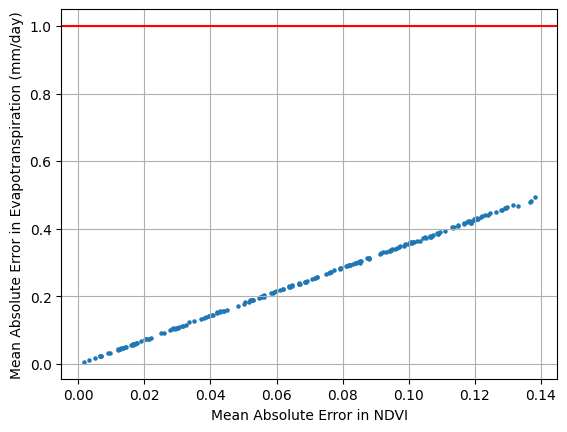

In [100]:
scatter = plt.scatter(x=df.NDVI_error, y=df.ET_error, s=5)
plt.xlabel('Mean Absolute Error in NDVI')
plt.ylabel('Mean Absolute Error in Evapotranspiration (mm/day)')
plt.grid(True)

# Add a horizontal red line at y=1
plt.axhline(y=1, color='red', linestyle='-')

plt.show()

In [102]:
np.nanmean((df.ET_error) / df.NDVI_error)

np.float64(3.5496376081531413)

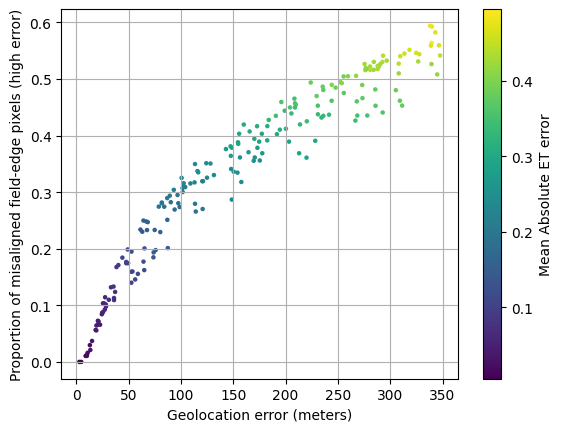

In [103]:
nps = np.prod(NDVI_error.shape)
plt.scatter(x=df.distance, y=df.num_higherror/nps, c=df.ET_error,s=5)
plt.colorbar(label='Mean Absolute ET error')
plt.xlabel('Geolocation error (meters)')
plt.ylabel('Proportion of misaligned field-edge pixels (high error)')
plt.grid(True)
plt.show()

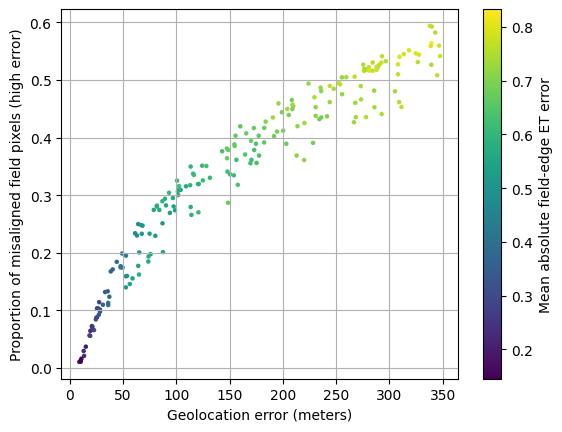

In [104]:
nps = np.prod(NDVI_error.shape)
plt.scatter(x=df.distance, y=df.num_higherror/nps, c=df.ET_hetero_error,s=5)
plt.colorbar(label='Mean absolute field-edge ET error')
plt.xlabel('Geolocation error (meters)')
plt.ylabel('Proportion of misaligned field pixels (high error)')
plt.grid(True)

plt.show()

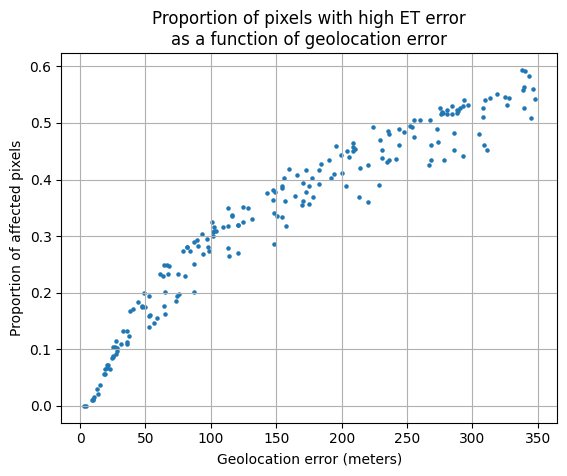

In [105]:
nps = np.prod(NDVI_error.shape)
plt.scatter(x=df.distance, y=df.num_higherror/nps,s=5)
plt.xlabel('Geolocation error (meters)')
plt.ylabel('Proportion of affected pixels')
plt.title('Proportion of pixels with high ET error\nas a function of geolocation error')
plt.grid(True)
plt.savefig("Proportion of high error pixels.png", bbox_inches="tight")

plt.show()
## farms here are roughly 10x10 pixels, so 5 pixel shift corresponding to roughly 50% of fields contaminated makes sense

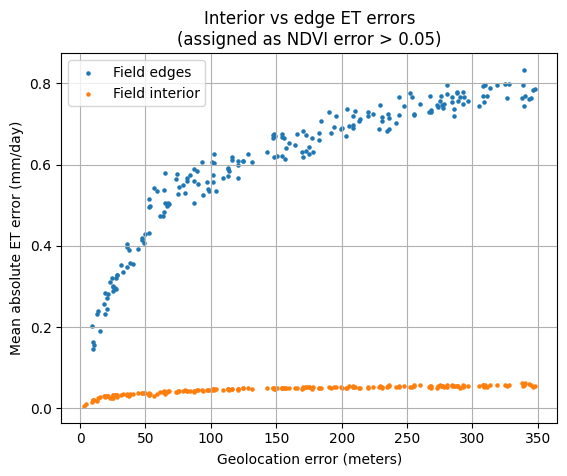

In [106]:
nps = np.prod(NDVI_error.shape)
plt.scatter(x=df.distance, y=df.ET_hetero_error, s=5, label="Field edges")
plt.scatter(x=df.distance, y=df.ET_homo_error, s=5, label="Field interior")
plt.legend()
# plt.axhline(y=np.sqrt((1-0.75**2))*28.94, c='red',linestyle='-', label="0.75 mm/day error")
# plt.axhline(y=np.sqrt((1-0.75**2))*100.94, c='red',linestyle='-', label="0.75 mm/day error")
plt.xlabel('Geolocation error (meters)')
plt.ylabel('Mean absolute ET error (mm/day)')
plt.title('Interior vs edge ET errors\n(assigned as NDVI error > 0.05)')
plt.grid(True)
plt.savefig("Interior vs edge of field ET errors.png", bbox_inches="tight")
plt.show()

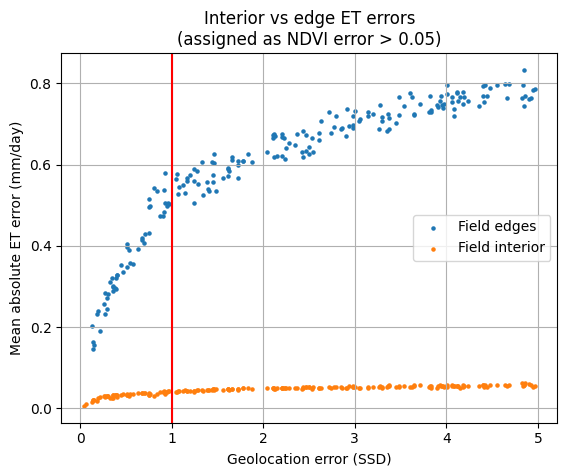

In [109]:
nps = np.prod(NDVI_error.shape)
plt.scatter(x=df.distance / 70, y=df.ET_hetero_error, s=5, label="Field edges")
plt.scatter(x=df.distance / 70, y=df.ET_homo_error, s=5, label="Field interior")
plt.legend()
plt.axvline(x=1, c="red", linestyle="-")
# plt.axhline(y=np.sqrt((1-0.75**2))*28.94, c='red',linestyle='-', label="0.75 mm/day error")
# plt.axhline(y=np.sqrt((1-0.75**2))*100.94, c='red',linestyle='-', label="0.75 mm/day error")
plt.xlabel('Geolocation error (SSD)')
plt.ylabel('Mean absolute ET error (mm/day)')
plt.title('Interior vs edge ET errors\n(assigned as NDVI error > 0.05)')
plt.grid(True)
plt.savefig("Interior vs edge of field ET errors.png", bbox_inches="tight")
plt.show()

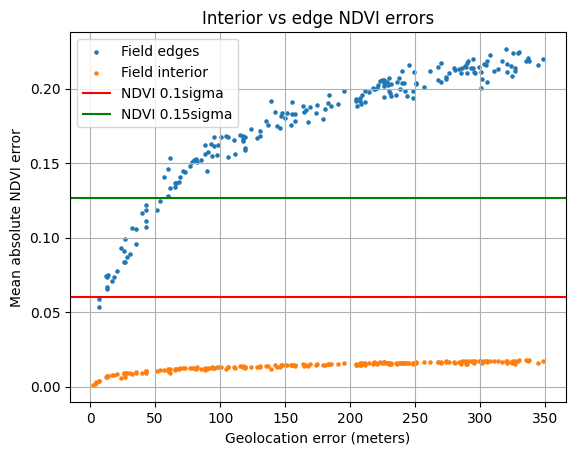

In [60]:
nps = np.prod(NDVI_error.shape)
plt.scatter(x=df.distance, y=df.NDVI_hetero_error, s=5, label="Field edges")
plt.scatter(x=df.distance, y=df.NDVI_homo_error, s=5, label="Field interior")
plt.axhline(y=ndvi_errorcutoff, c='red',linestyle='-', label="NDVI 0.1sigma")
plt.axhline(y=np.sqrt(0.15**2 - 0.08**2), c='green',linestyle='-', label="NDVI 0.15sigma")
plt.legend()
plt.xlabel('Geolocation error (meters)')
plt.ylabel('Mean absolute NDVI error')
plt.title('Interior vs edge NDVI errors')
plt.grid(True)
plt.savefig("Interior vs edge of field NDVI errors.png", bbox_inches="tight")
plt.show()